In [1]:
import keras_tuner as kt
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import shap
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
import shap
from sklearn.dummy import DummyClassifier

In [2]:
####################################################### load dataframe
# Load dataset from ppi.csv
df = pd.read_csv("ppi.csv")

base_folder = f"results/residue/"
os.makedirs(base_folder, exist_ok=True)

default_folder = f"results/residue/default"
over_folder = f"results/residue/over"
under_folder = f"results/residue/under"
os.makedirs(default_folder, exist_ok=True)
os.makedirs(over_folder, exist_ok=True)
os.makedirs(under_folder, exist_ok=True)


In [3]:
####################################################### fix sequence in DF
# Define the set of standard amino acids
standard_aas = set("ACDEFGHIKLMNPQRSTVWY")

# detect non-standard amino acids in a sequence (here, each sequence is a single letter)
def has_non_standard(seq):
    return seq not in standard_aas

# identify rows where sequence contains a non-standard amino acid
non_standard_mask = df["sequence"].apply(has_non_standard)

if non_standard_mask.any():
    print("Found non-standard amino acids in the following rows:")
    print(df.loc[non_standard_mask, ["uniprot_id", "sequence"]])
    # Remove rows with non-standard amino acids
    df = df.loc[~non_standard_mask].copy()
else:
    print("All sequences contain standard amino acids.")
    

seq_dummies = pd.get_dummies(df["sequence"], prefix="aa")

# Ensure that we have columns for all 20 standard amino acids (in case some letters are missing in the data)
aa_order = "ACDEFGHIKLMNPQRSTVWY"
expected_cols = [f"aa_{aa}" for aa in aa_order]
seq_dummies = seq_dummies.reindex(columns=expected_cols, fill_value=0)

# Drop the original sequence column and concatenate the one-hot encoded columns
df = df.drop(columns=["sequence"])
df = pd.concat([df, seq_dummies], axis=1)



Found non-standard amino acids in the following rows:
      uniprot_id sequence
29636     Q01786        X



Class Distribution:
p_interface
0    57304
1     7845
Name: count, dtype: int64


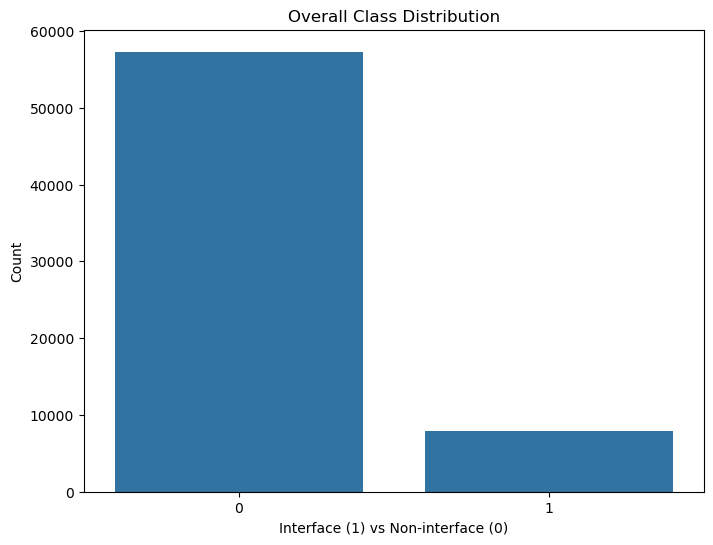

In [4]:
######################################################## check overall class distrubution
# Check overall class distribution for the target
target = "p_interface"
class_counts = df[target].value_counts()
print("\nClass Distribution:")
print(class_counts)

# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=df)
plt.title("Overall Class Distribution")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()

In [5]:
########################################################## make train, validation and test split
# Count the number of unique proteins based on uniprot_id
unique_proteins = df['uniprot_id'].nunique()
print("\nNumber of Unique Proteins (uniprot_id):", unique_proteins)

# Explore the class distribution per protein
protein_class_distribution = df.groupby('uniprot_id')[target].value_counts().unstack().fillna(0)
print("\nProtein-wise Class Distribution (first 5 proteins):")
print(protein_class_distribution.head())

# Define target and keep uniprot_id for splitting (we'll drop it later)
target = "p_interface"

# Get unique uniprot_ids to use as groups
unique_groups = df['uniprot_id'].unique()

# First split: 80% train and 20% temporary (which will be split into validation and test)
train_groups, temp_groups= train_test_split(unique_groups, test_size=0.2, random_state=22)

# Second split: Split the temporary groups into validation and test equally (10% each)
val_groups, test_groups = train_test_split(temp_groups, test_size=0.5, random_state=42)

# Create the train, validation, and test dataframes by filtering on uniprot_id groups
train_df = df[df['uniprot_id'].isin(train_groups)]
val_df   = df[df['uniprot_id'].isin(val_groups)]
test_df  = df[df['uniprot_id'].isin(test_groups)]

########
train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
val_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
test_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])

# Define features and target for each split.
# Drop the columns "uniprot_id", "domain", etc.
X_train = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train = train_df[target]

X_val = val_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_val = val_df[target]

X_test = test_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_test = test_df[target]


Number of Unique Proteins (uniprot_id): 228

Protein-wise Class Distribution (first 5 proteins):
p_interface    0   1
uniprot_id          
A0A010       185  75
A0A024RAV5   175  13
A0A0D5YE19   290  26
A0A0F4FI39   324  10
A0A0H2VDD2   199   8


In [6]:
####################################### calcualte class weight of train on the validation
#class_weights = compute_class_weight("balanced", classes=np.unique(y_val), y=y_val)
#class_weights = {cls: weight for cls, weight in zip(np.unique(y_val), class_weights)}
#print(class_weights)

In [7]:
######################################### check overlap

# Check that the splits have disjoint uniprot_ids
train_ids = set(train_df['uniprot_id'])
val_ids   = set(val_df['uniprot_id'])
test_ids  = set(test_df['uniprot_id'])

print("Overlap between Train & Validation:", train_ids.intersection(val_ids))
print("Overlap between Train & Test:", train_ids.intersection(test_ids))
print("Overlap between Validation & Test:", val_ids.intersection(test_ids))

print("Unique uniprot_ids in Train:", train_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Validation:", val_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Test:", test_df["uniprot_id"].nunique())

Overlap between Train & Validation: set()
Overlap between Train & Test: set()
Overlap between Validation & Test: set()
Unique uniprot_ids in Train: 182
Unique uniprot_ids in Validation: 23
Unique uniprot_ids in Test: 23


In [8]:
######################################### Undersampling and Ovesampling
# Initialize the RandomUnderSampler
rus_50 = RandomUnderSampler(random_state=42)
rus_30 = RandomUnderSampler(random_state=42,sampling_strategy=0.35)

# apply the undersampler on the training data
X_train_undersampled, y_train_undersampled = rus_30.fit_resample(X_train, y_train)

smote = SMOTE(random_state=42, sampling_strategy=0.35)

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)


class_counts_u = y_train_undersampled.value_counts()
class_percentages_u = y_train_undersampled.value_counts(normalize=True) * 100

print("\nClass Distribution after Undersampling:")
for cls, count in class_counts_u.items():
    percentage = class_percentages_u[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")

class_counts_o = y_train_oversampled.value_counts()
class_percentages_o = y_train_oversampled.value_counts(normalize=True) * 100

print("\nClass Distribution after Oversampling:")
for cls, count in class_counts_o.items():
    percentage = class_percentages_o[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")


C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Class Distribution after Undersampling:
Class 0: 17702 samples (74.07%)
Class 1: 6196 samples (25.93%)

Class Distribution after Oversampling:
Class 0: 45449 samples (74.07%)
Class 1: 15907 samples (25.93%)



Class Distribution:
Class 0: 45449 samples (88.00%)
Class 1: 6196 samples (12.00%)


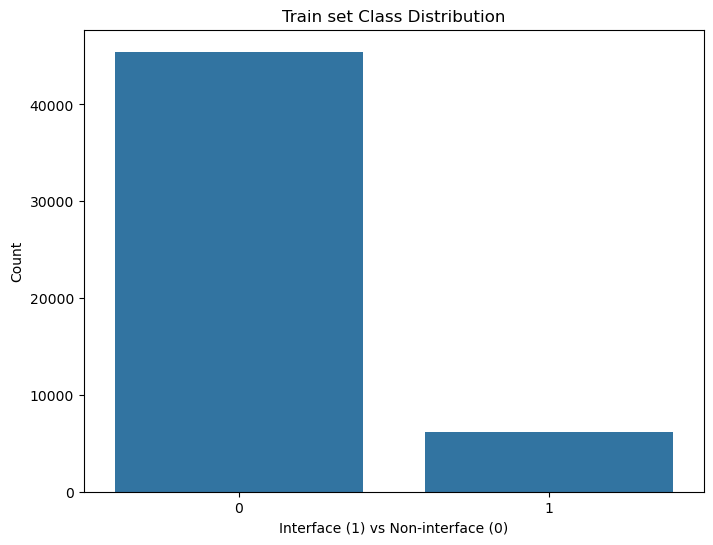

In [9]:
######################################################## check class distrubution for training set
target = "p_interface"
initial_class_counts = train_df[target].value_counts()
initial_class_percentages = train_df[target].value_counts(normalize=True) * 100

print("\nClass Distribution:")
for cls, count in initial_class_counts.items():
    percentage = initial_class_percentages[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")


# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=train_df)
plt.title("Train set Class Distribution")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()


In [10]:
######################################### Undersampling and Ovesampling
# Initialize the RandomUnderSampler
rus_50 = RandomUnderSampler(random_state=42)
rus_30 = RandomUnderSampler(random_state=42,sampling_strategy=0.35)

# apply the undersampler on the training data
X_train_undersampled, y_train_undersampled = rus_30.fit_resample(X_train, y_train)

smote = SMOTE(random_state=42, sampling_strategy=0.35)

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)


class_counts_u = y_train_undersampled.value_counts()
class_percentages_u = y_train_undersampled.value_counts(normalize=True) * 100

print("\nClass Distribution after Undersampling:")
for cls, count in class_counts_u.items():
    percentage = class_percentages_u[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")

class_counts_o = y_train_oversampled.value_counts()
class_percentages_o = y_train_oversampled.value_counts(normalize=True) * 100

print("\nClass Distribution after Oversampling:")
for cls, count in class_counts_o.items():
    percentage = class_percentages_o[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")


C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Class Distribution after Undersampling:
Class 0: 17702 samples (74.07%)
Class 1: 6196 samples (25.93%)

Class Distribution after Oversampling:
Class 0: 45449 samples (74.07%)
Class 1: 15907 samples (25.93%)


In [11]:
####################################### calcualte class weight of train on the validation
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
print(class_weights)


{0: 0.5681643160465577, 1: 4.167608134280181}


<Figure size 800x500 with 0 Axes>

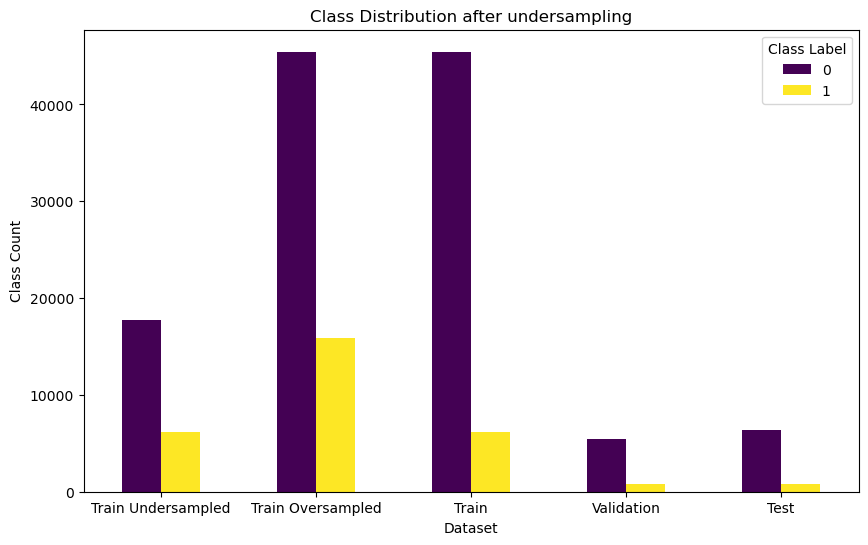

In [12]:
# Count occurrences of each class in train, val, and test sets
train_counts_under = y_train_undersampled.value_counts().sort_index()
train_counts_over = y_train_oversampled.value_counts().sort_index()
train_counts = y_train.value_counts().sort_index()
val_counts = y_val.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

# Create a DataFrame for visualization
class_distribution = pd.DataFrame({
    "Train Undersampled": train_counts_under,
    "Train Oversampled": train_counts_over,
    "Train": train_counts,
    "Validation": val_counts,
    "Test": test_counts
}).T  # Transpose for better plotting

# Plot the class distribution
plt.figure(figsize=(8, 5))
class_distribution.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.xlabel("Dataset")
plt.ylabel("Class Count")
plt.title("Class Distribution after undersampling")
plt.xticks(rotation=0)
plt.legend(title="Class Label")
plt.show()


In [13]:
################################################## scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train_undersampled = scaler.fit_transform(X_train_undersampled)
X_train_oversampled = scaler.fit_transform(X_train_oversampled)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

Confusion Matrix:
[[6394    0]
 [ 823    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



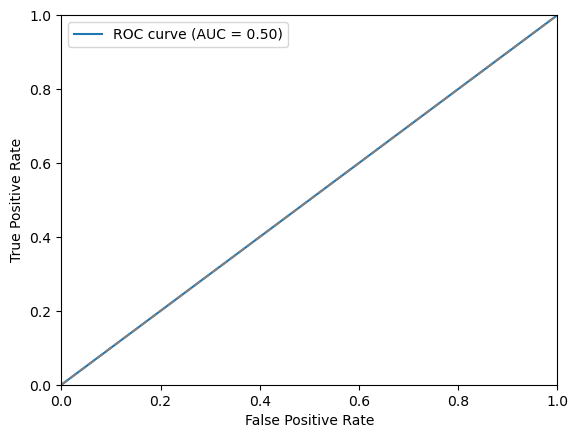

In [14]:
################################################## Dummy Classifier

# Create a majority class classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit on the training data
dummy_clf.fit(X_train, y_train)

# Predict on the test set
#y_pred_dummy = dummy_clf.predict(X_test)
# Predict probabilities for the positive class (class 1)
y_prob_dummy = dummy_clf.predict_proba(X_test)[:, 1]
# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_dummy = (y_prob_dummy >= 0.5).astype(int)


# Compute ROC curve and AUC
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test, y_pred_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_prob_dummy))
print("\nClassification Report:")
print(classification_report(y_test, y_prob_dummy, zero_division=0))

plt.plot(fpr_dummy, tpr_dummy, label=f"ROC curve (AUC = {roc_auc_dummy:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [91]:
#################################################### Logistic regression 
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix

# Initialize and fit the Logistic Regression model
model = model = LogisticRegression( 
    max_iter=10000,       
    class_weight='balanced' 
)
model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_pred_proba_LR = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_LR = (y_pred_proba_LR >= 0.5).astype(int)

f1_LR = f1_score(y_test, y_pred_LR, zero_division=0)
# Calculate log loss
loss = log_loss(y_test, y_pred_proba_LR)
print("Log Loss: {:.4f}".format(loss))

# Calculate accuracy for reference
accuracy = accuracy_score(y_test, y_pred_LR)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_LR))



Log Loss: 0.5301
Accuracy: 72.40%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      6394
           1       0.20      0.49      0.29       823

    accuracy                           0.72      7217
   macro avg       0.56      0.62      0.56      7217
weighted avg       0.84      0.72      0.77      7217



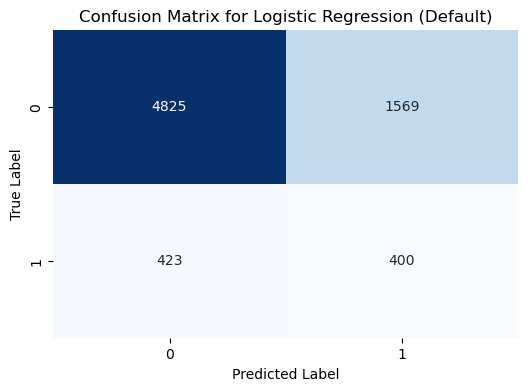

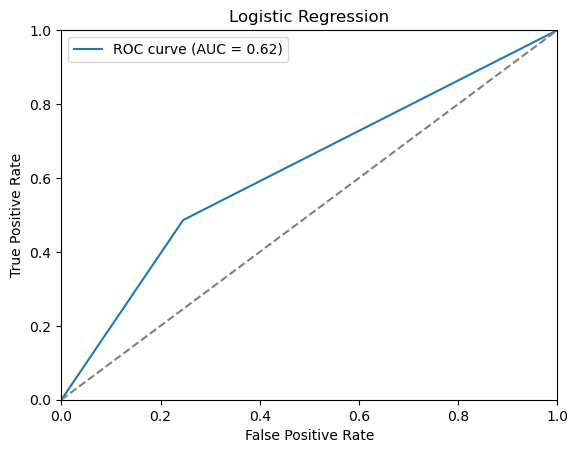

In [93]:
################################################# print results Logistic regression
# Compute confusion matrix
cm_LR = confusion_matrix(y_test, y_pred_LR)


# Plot confusion matrix using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_LR, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Logistic Regression (Default)") 
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "default", "Confusion Matrix for Logistic Regression (Default).png"))
plt.show()

# Compute ROC curve with continuous probabilities
fpr_LR, tpr_LR, thresholds = roc_curve(y_test, y_pred_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

plt.plot(fpr_LR, tpr_LR, label=f"ROC curve (AUC = {roc_auc_LR:.2f})")


plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(os.path.join(base_folder, "default", "ROC Curve for Logistic Regression (Default).png"))
plt.show()

Log Loss: 0.5518
Accuracy: 71.12%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      6394
           1       0.20      0.51      0.29       823

    accuracy                           0.71      7217
   macro avg       0.56      0.62      0.55      7217
weighted avg       0.84      0.71      0.76      7217



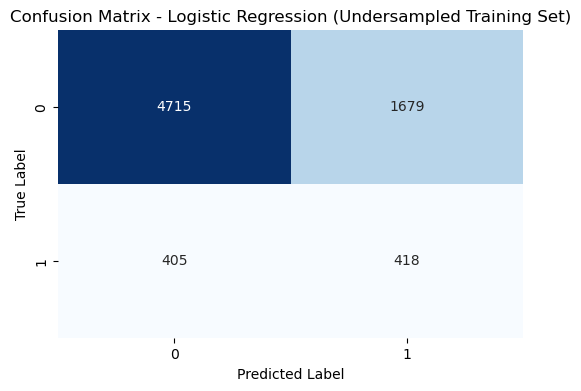

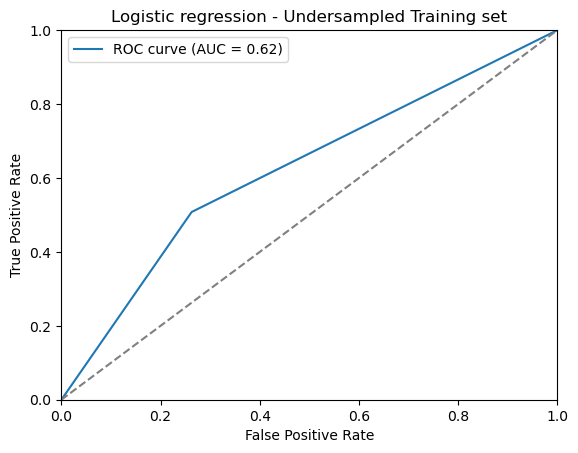

In [95]:
#################################################### Logistic regression - Undersampled Training set 
# Initialize and fit the Logistic Regression model
model = model = LogisticRegression( 
    max_iter=10000,       
    class_weight='balanced' 
)
model.fit(X_train_undersampled, y_train_undersampled)

# Predict probabilities for the positive class
y_pred_proba_LR_under = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_LR_under = (y_pred_proba_LR_under >= 0.5).astype(int)


# Calculate log loss
loss = log_loss(y_test, y_pred_proba_LR_under)
print("Log Loss: {:.4f}".format(loss))
f1_LR_under = f1_score(y_test, y_pred_LR_under, zero_division=0)
# Calculate accuracy for reference
accuracy = accuracy_score(y_test, y_pred_LR_under)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_LR_under))

cm_LR_under = confusion_matrix(y_test, y_pred_LR_under)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_LR_under, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Logistic Regression (Undersampled Training Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "under", "Confusion Matrix - Logistic Regression (Undersampled Training Set).png"))
plt.show()

# Compute ROC curve with continuous probabilities
fpr_LR_under, tpr_LR_under, thresholds_under = roc_curve(y_test, y_pred_LR_under)
roc_auc_LR_under = auc(fpr_LR_under, tpr_LR_under)

plt.plot(fpr_LR_under, tpr_LR_under, label=f"ROC curve (AUC = {roc_auc_LR_under:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Logistic regression - Undersampled Training set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(os.path.join(base_folder, "under", "ROC Curve - Logistic Regression (Undersampled Training Set).png"))
plt.show()


Log Loss: 0.5560
Accuracy: 71.64%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      6394
           1       0.20      0.49      0.28       823

    accuracy                           0.72      7217
   macro avg       0.56      0.62      0.55      7217
weighted avg       0.84      0.72      0.76      7217



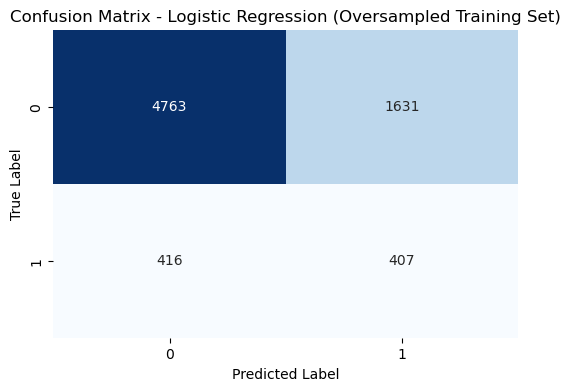

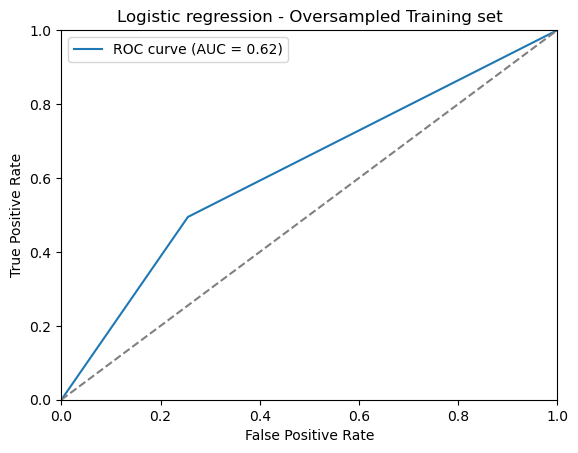

In [97]:
#################################################### Logistic regression - Oversampled Training set 
# Initialize and fit the Logistic Regression model
model = model = LogisticRegression( 
    max_iter=10000,       
    class_weight='balanced' 
)
model.fit(X_train_oversampled, y_train_oversampled)

# Predict probabilities for the positive class
y_pred_proba_LR_over = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_LR_over = (y_pred_proba_LR_over >= 0.5).astype(int)

# Calculate log loss
loss = log_loss(y_test, y_pred_proba_LR_over)
print("Log Loss: {:.4f}".format(loss))
f1_LR_over = f1_score(y_test, y_pred_LR_over, zero_division=0)
# Calculate accuracy for reference
accuracy = accuracy_score(y_test, y_pred_LR_over)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_LR_over))

# Compute and plot confusion matrix for Logistic Regression (Oversampled Training set)
cm_LR_over = confusion_matrix(y_test, y_pred_LR_over)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_LR_over, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Logistic Regression (Oversampled Training Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "over", "Confusion Matrix - Logistic Regression (Oversampled Training Set).png"))

plt.show()

# Compute ROC curve with continuous probabilities
fpr_LR_over, tpr_LR_over, thresholds_over = roc_curve(y_test, y_pred_LR_over)
roc_auc_LR_over = auc(fpr_LR_over, tpr_LR_over)

plt.plot(fpr_LR_over, tpr_LR_over, label=f"ROC curve (AUC = {roc_auc_LR_over:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Logistic regression - Oversampled Training set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(os.path.join(base_folder, "over", "ROC Curve - Logistic Regression (Oversampled Training Set).png"))
plt.show()


In [19]:
###################################################### hyperparamtater tuning Random Foretst
param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

###################################################### set the class weights here

grid_RF = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight=class_weights), 
    param_grid_RF,
    scoring='f1',
    n_jobs=-1
)
grid_RF.fit(X_val, y_val)

print("----- Random Forest Hyperparameter Tuning -----")
print("Best Parameters (RF):", grid_RF.best_params_)
print("Best Validation Accuracy (RF):", grid_RF.best_score_)
best_rf = grid_RF.best_estimator_


----- Random Forest Hyperparameter Tuning -----
Best Parameters (RF): {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best Validation Accuracy (RF): 0.16230115189938615


Accuracy: 0.68
Precision: 0.18
Recall: 0.51
F1 Score: 0.27
              precision    recall  f1-score   support

           0       0.92      0.70      0.80      6394
           1       0.18      0.51      0.27       823

    accuracy                           0.68      7217
   macro avg       0.55      0.61      0.53      7217
weighted avg       0.83      0.68      0.74      7217



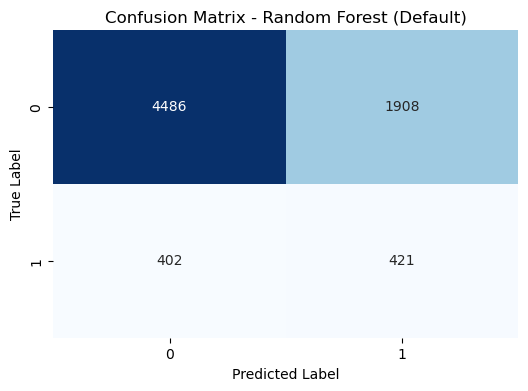

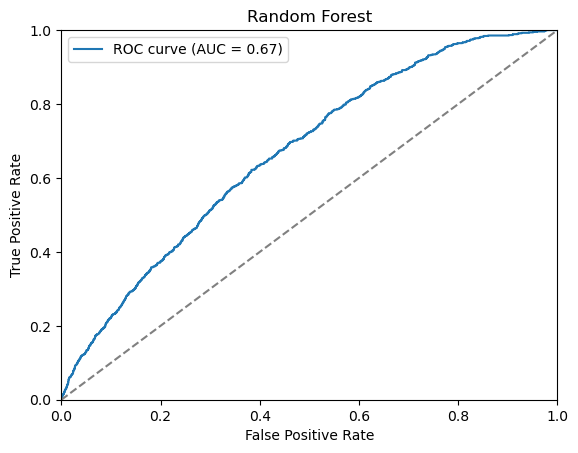

In [103]:
################################################# run RF on trainings data
# fit on training data 
best_rf.fit(X_train, y_train)

y_pred_RF = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_RF = (y_pred_RF >= 0.5).astype(int)

# Evaluate
accuracy_RF  = accuracy_score(y_test, y_pred_class_RF)
precision_RF = precision_score(y_test, y_pred_class_RF, zero_division=0)
recall_RF    = recall_score(y_test, y_pred_class_RF, zero_division=0)
f1_RF        = f1_score(y_test, y_pred_class_RF, zero_division=0)

############################################################### print score radndom forest

print(f"Accuracy: {accuracy_RF:.2f}")
print(f"Precision: {precision_RF:.2f}")
print(f"Recall: {recall_RF:.2f}")
print(f"F1 Score: {f1_RF:.2f}")

print(classification_report(y_test, y_pred_class_RF, zero_division=0))

# Compute and plot confusion matrix for Random Forest
cm_RF = confusion_matrix(y_test, y_pred_class_RF)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_RF, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Random Forest (Default)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "default", "Confusion Matrix - Random Forest (Default).png"))
plt.show()


# Use continuous probabilities for the ROC curve
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.plot(fpr_RF, tpr_RF, label=f"ROC curve (AUC = {roc_auc_RF:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(os.path.join(base_folder, "default", "ROC Curve - Random Forest (Default).png"))

plt.show()

Accuracy: 0.27
Precision: 0.13
Recall: 0.97
F1 Score: 0.23
              precision    recall  f1-score   support

           0       0.98      0.17      0.30      6394
           1       0.13      0.97      0.23       823

    accuracy                           0.27      7217
   macro avg       0.56      0.57      0.26      7217
weighted avg       0.88      0.27      0.29      7217



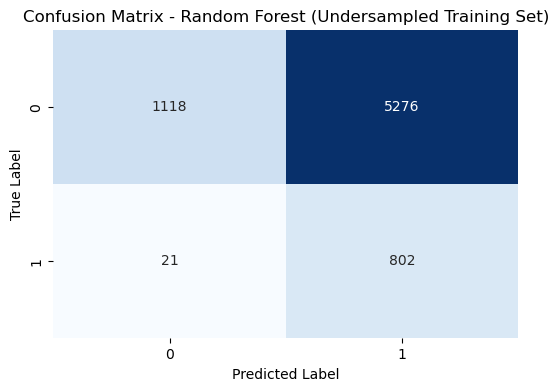

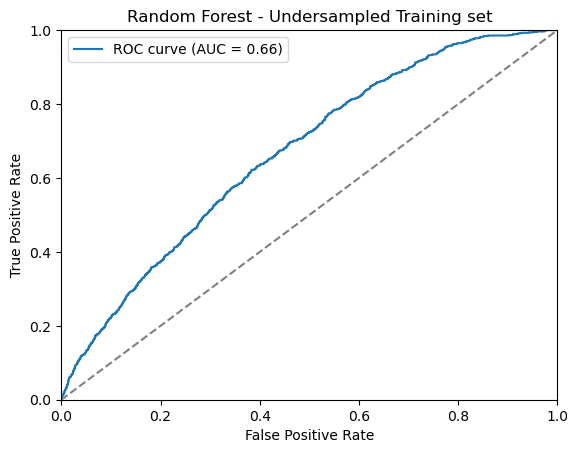

In [101]:
################################################# run RF on training data UNDERSAMPLED
# fit on trainingsdata 
best_rf.fit(X_train_undersampled, y_train_undersampled)

y_pred_RF = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_RF = (y_pred_RF >= 0.5).astype(int)

# Evaluate
accuracy_RF  = accuracy_score(y_test, y_pred_class_RF)
precision_RF = precision_score(y_test, y_pred_class_RF, zero_division=0)
recall_RF    = recall_score(y_test, y_pred_class_RF, zero_division=0)
f1_RF_under       = f1_score(y_test, y_pred_class_RF, zero_division=0)

############################################################### print score radndom forest
print(f"Accuracy: {accuracy_RF:.2f}")
print(f"Precision: {precision_RF:.2f}")
print(f"Recall: {recall_RF:.2f}")
print(f"F1 Score: {f1_RF_under:.2f}")

print(classification_report(y_test, y_pred_class_RF, zero_division=0))

cm_RF_under = confusion_matrix(y_test, y_pred_class_RF)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_RF_under, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Random Forest (Undersampled Training Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "under", "Confusion Matrix - Random Forest (Undersampled Training Set).png"))
plt.show()

# Use continuous probabilities for the ROC curve
fpr_RF_under, tpr_RF_under, thresholds = roc_curve(y_test, y_pred_RF)
roc_auc_RF_under = auc(fpr_RF_under, tpr_RF_under)

plt.plot(fpr_RF, tpr_RF, label=f"ROC curve (AUC = {roc_auc_RF_under:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Random Forest - Undersampled Training set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(os.path.join(base_folder, "under", "ROC Curve - Random Forest (Undersampled Training Set).png"))
plt.show()

Accuracy: 0.27
Precision: 0.13
Recall: 0.96
F1 Score: 0.23
              precision    recall  f1-score   support

           0       0.97      0.18      0.30      6394
           1       0.13      0.96      0.23       823

    accuracy                           0.27      7217
   macro avg       0.55      0.57      0.26      7217
weighted avg       0.88      0.27      0.29      7217



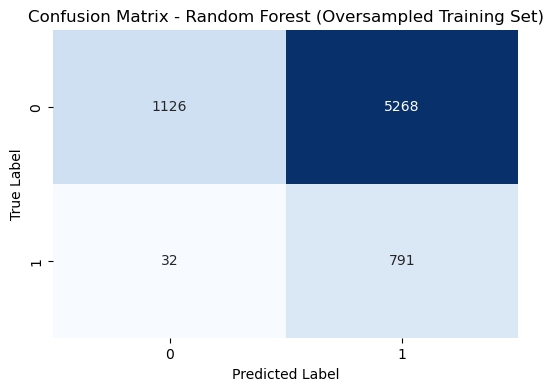

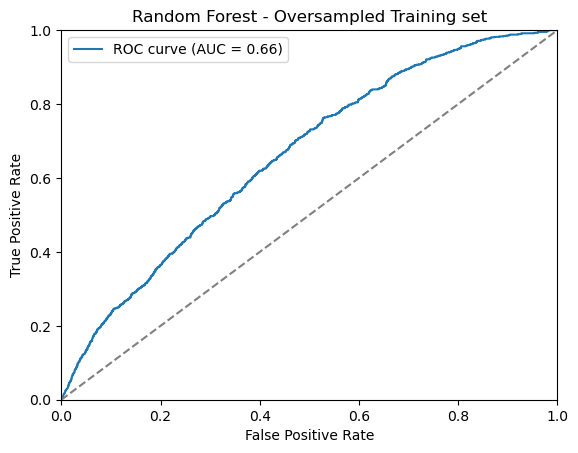

In [22]:
################################################# run RF on trainings data OVERSAMPLED
# fit on trainingsdata 
best_rf.fit(X_train_oversampled, y_train_oversampled)

# Predict probabilities on the test set (probability for the positive class)
y_pred_RF_over = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_RF_over = (y_pred_RF_over >= 0.5).astype(int)

# Evaluate predictions
accuracy_RF_over  = accuracy_score(y_test, y_pred_class_RF_over)
precision_RF_over = precision_score(y_test, y_pred_class_RF_over, zero_division=0)
recall_RF_over    = recall_score(y_test, y_pred_class_RF_over, zero_division=0)
f1_RF_over        = f1_score(y_test, y_pred_class_RF_over, zero_division=0)

###############################################################
# Print Random Forest performance scores
print(f"Accuracy: {accuracy_RF_over:.2f}")
print(f"Precision: {precision_RF_over:.2f}")
print(f"Recall: {recall_RF_over:.2f}")
print(f"F1 Score: {f1_RF_over:.2f}")

print(classification_report(y_test, y_pred_class_RF_over, zero_division=0))


# Compute and plot confusion matrix for Random Forest - Oversampled Training set
cm_RF_over = confusion_matrix(y_test, y_pred_class_RF_over)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_RF_over, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Random Forest (Oversampled Training Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "over", "Confusion Matrix for Random Forest (Over).png"))

plt.show()


# Use continuous probabilities for the ROC curve
fpr_RF_over, tpr_RF_over, thresholds = roc_curve(y_test, y_pred_RF_over)
roc_auc_RF_over = auc(fpr_RF_over, tpr_RF_over)

plt.plot(fpr_RF_over, tpr_RF_over, label=f"ROC curve (AUC = {roc_auc_RF_over:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Random Forest - Oversampled Training set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(os.path.join(base_folder, "over", "ROC Curve for Random Forest (Over).png"))
plt.show()

In [23]:
# Compute the ratio from the validation set: (number of negatives / number of positives)
ratio_val = (len(y_val) - sum(y_val)) / sum(y_val)
print("Validation set ratio (negatives/positives):", ratio_val)

# Define hyperparameter grid for XGBoost
param_grid_XGB = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Setup GridSearchCV with XGBClassifier, using scale_pos_weight to account for the validation set ratio
grid_XGB = GridSearchCV(
    XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=ratio_val  # using the ratio computed from the validation set
    ),
    param_grid_XGB, 
    scoring='f1',
    n_jobs=-1
)

# Perform hyperparameter tuning on the validation set
grid_XGB.fit(X_val, y_val)

# Print best hyperparameters and best validation accuracy
print("----- XGBoost Hyperparameter Tuning -----")
print("Best Parameters (XGB):", grid_XGB.best_params_)
print("Best Validation Accuracy (XGB):", grid_XGB.best_score_)

# Get the best model
best_xgb = grid_XGB.best_estimator_


Validation set ratio (negatives/positives): 6.61138014527845


C:\Users\youpz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:25:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


----- XGBoost Hyperparameter Tuning -----
Best Parameters (XGB): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Validation Accuracy (XGB): 0.12889765652525187


C:\Users\youpz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:25:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Performance:
Accuracy: 0.75
Precision: 0.21
Recall: 0.42
F1 Score: 0.28

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      6394
           1       0.21      0.42      0.28       823

    accuracy                           0.75      7217
   macro avg       0.56      0.61      0.56      7217
weighted avg       0.83      0.75      0.78      7217



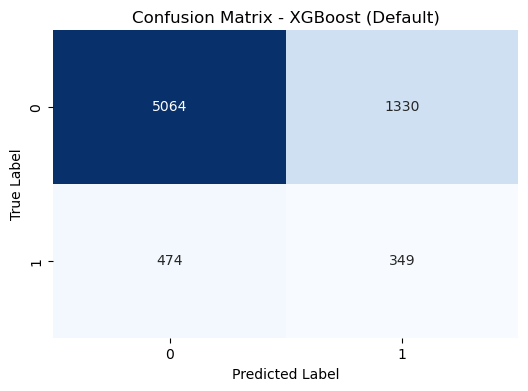

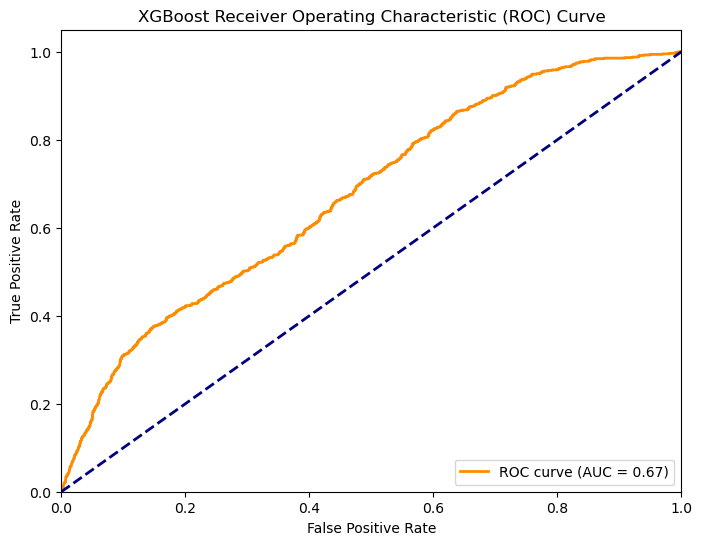

In [24]:
############################################### running XGBoost

# Re-fit the best estimator using the training data (X_train, y_train)
best_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_XGB = best_xgb.predict_proba(X_test)[:, 1]
# Convert probabilities to binary class predictions using a threshold of 0.5
y_pred_class_XGB = [1 if prob >= 0.5 else 0 for prob in y_pred_XGB]

# Evaluate the classifier
accuracy_XGB = accuracy_score(y_test, y_pred_class_XGB)
precision_XGB = precision_score(y_test, y_pred_class_XGB, zero_division=0)
recall_XGB = recall_score(y_test, y_pred_class_XGB, zero_division=0)
f1_XGB = f1_score(y_test, y_pred_class_XGB, zero_division=0)

############################################### printing score XGBoost
print("XGBoost Classifier Performance:")
print(f"Accuracy: {accuracy_XGB:.2f}")
print(f"Precision: {precision_XGB:.2f}")
print(f"Recall: {recall_XGB:.2f}")
print(f"F1 Score: {f1_XGB:.2f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_XGB, zero_division=0))

# Compute the ROC curve and ROC-AUC using the predicted probabilities
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test, y_pred_XGB)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)

# Compute and plot confusion matrix for XGBoost
cm_XGB = confusion_matrix(y_test, y_pred_class_XGB)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_XGB, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - XGBoost (Default)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "default", "Confusion Matrix - XGBoost (Default).png"))

plt.show()


# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGB, tpr_XGB, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_XGB:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(base_folder, "default", "ROC Curve - XGBoost (Default).png"))

plt.show()

C:\Users\youpz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:25:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Performance (Undersampled Training Data):
Accuracy: 0.43
Precision: 0.15
Recall: 0.82
F1 Score: 0.25

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.39      0.55      6394
           1       0.15      0.82      0.25       823

    accuracy                           0.43      7217
   macro avg       0.54      0.60      0.40      7217
weighted avg       0.85      0.43      0.51      7217



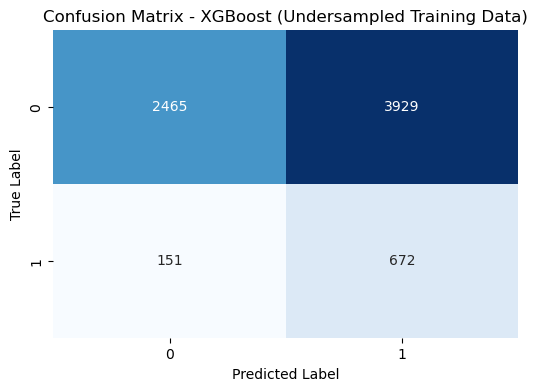

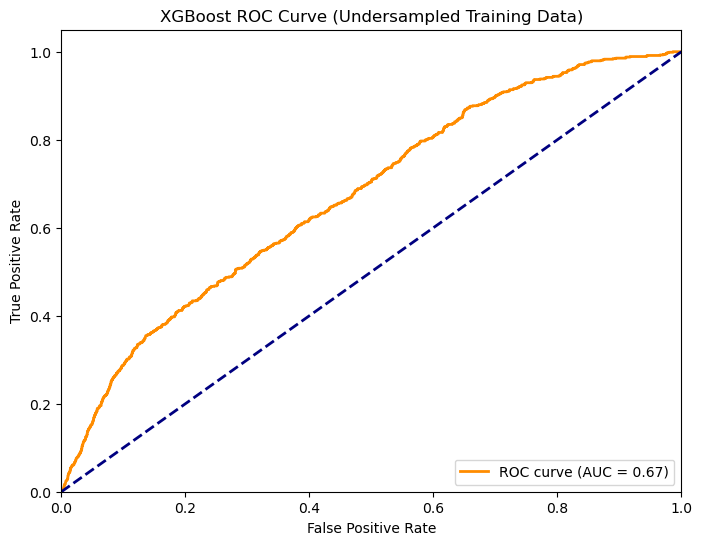

In [25]:
############################################## running XGBoost with undersampled training data

# Re-fit the best estimator using the undersampled training data (ensure you pass both features and labels)
best_xgb.fit(X_train_undersampled, y_train_undersampled)

# Predict on the test set using probability estimates for the positive class
y_pred_XGB_under = best_xgb.predict_proba(X_test)[:, 1]

# Convert probabilities to binary class predictions using a threshold of 0.5
y_pred_class_XGB_under = [1 if prob >= 0.5 else 0 for prob in y_pred_XGB_under]

# Evaluate the classifier
accuracy_XGB_under = accuracy_score(y_test, y_pred_class_XGB_under)
precision_XGB_under = precision_score(y_test, y_pred_class_XGB_under, zero_division=0)
recall_XGB_under = recall_score(y_test, y_pred_class_XGB_under, zero_division=0)
f1_XGB_under = f1_score(y_test, y_pred_class_XGB_under, zero_division=0)

############################################### printing score XGBoost (Undersampled Training Data)
print("XGBoost Classifier Performance (Undersampled Training Data):")
print(f"Accuracy: {accuracy_XGB_under:.2f}")
print(f"Precision: {precision_XGB_under:.2f}")
print(f"Recall: {recall_XGB_under:.2f}")
print(f"F1 Score: {f1_XGB_under:.2f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_XGB_under, zero_division=0))

cm_XGB_under = confusion_matrix(y_test, y_pred_class_XGB_under)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_XGB_under, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - XGBoost (Undersampled Training Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "under", "Confusion Matrix - XGBoost (Undersampled Training Data).png"))

plt.show() 

# Compute the ROC curve and ROC-AUC using the predicted probabilities
fpr_XGB_under, tpr_XGB_under, thresholds_XGB_under = roc_curve(y_test, y_pred_XGB_under)
roc_auc_XGB_under = auc(fpr_XGB_under, tpr_XGB_under)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGB_under, tpr_XGB_under, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_XGB_under:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve (Undersampled Training Data)')
plt.legend(loc='lower right')
plt.savefig(os.path.join(base_folder, "under", "ROC Curve - XGBoost (Undersampled Training Data).png"))

plt.show()



C:\Users\youpz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Performance (Oversampled Training Data):
Accuracy: 0.33
Precision: 0.14
Recall: 0.92
F1 Score: 0.24

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.25      0.40      6394
           1       0.14      0.92      0.24       823

    accuracy                           0.33      7217
   macro avg       0.55      0.58      0.32      7217
weighted avg       0.86      0.33      0.38      7217



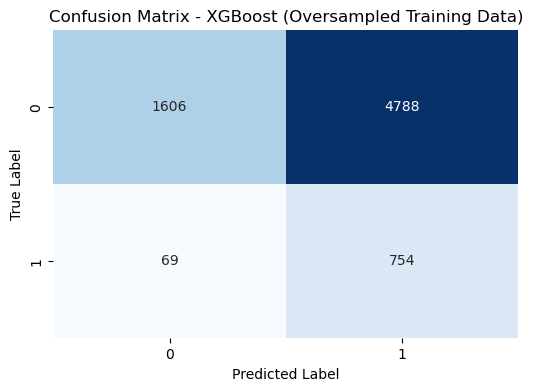

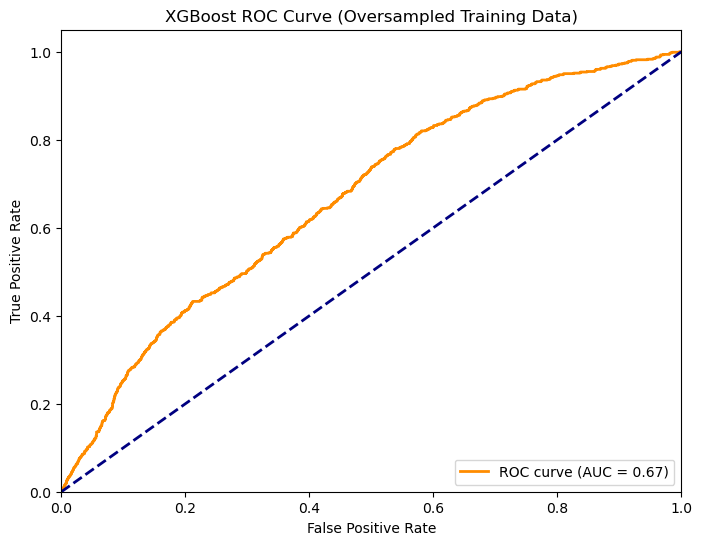

In [26]:
############################################### running XGBoost with oversampled training data

# Re-fit the best estimator using the oversampled training data (ensure you pass both features and labels)
best_xgb.fit(X_train_oversampled, y_train_oversampled)

# Predict on the test set using probability estimates for the positive class
y_pred_XGB_over = best_xgb.predict_proba(X_test)[:, 1]

# Convert probabilities to binary class predictions using a threshold of 0.5
y_pred_class_XGB_over = [1 if prob >= 0.5 else 0 for prob in y_pred_XGB_over]

# Evaluate the classifier
accuracy_XGB_over = accuracy_score(y_test, y_pred_class_XGB_over)
precision_XGB_over = precision_score(y_test, y_pred_class_XGB_over, zero_division=0)
recall_XGB_over = recall_score(y_test, y_pred_class_XGB_over, zero_division=0)
f1_XGB_over = f1_score(y_test, y_pred_class_XGB_over, zero_division=0)

############################################### printing score XGBoost (Oversampled Training Data)
print("XGBoost Classifier Performance (Oversampled Training Data):")
print(f"Accuracy: {accuracy_XGB_over:.2f}")
print(f"Precision: {precision_XGB_over:.2f}")
print(f"Recall: {recall_XGB_over:.2f}")
print(f"F1 Score: {f1_XGB_over:.2f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_XGB_over, zero_division=0))

# Compute and plot confusion matrix for XGBoost (Oversampled Training Data)
cm_XGB_over = confusion_matrix(y_test, y_pred_class_XGB_over)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_XGB_over, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - XGBoost (Oversampled Training Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "over", "Confusion Matrix - XGBoost (Oversampled Training Data).png"))

plt.show()


# Compute the ROC curve and ROC-AUC using the predicted probabilities
fpr_XGB_over, tpr_XGB_over, thresholds_XGB_over = roc_curve(y_test, y_pred_XGB_over)
roc_auc_XGB_over = auc(fpr_XGB_over, tpr_XGB_over)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGB_over, tpr_XGB_over, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_XGB_over:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve (Oversampled Training Data)')
plt.legend(loc='lower right')
plt.savefig(os.path.join(base_folder, "over", "ROC Curve - XGBoost (Oversampled Training Data).png"))

plt.show()


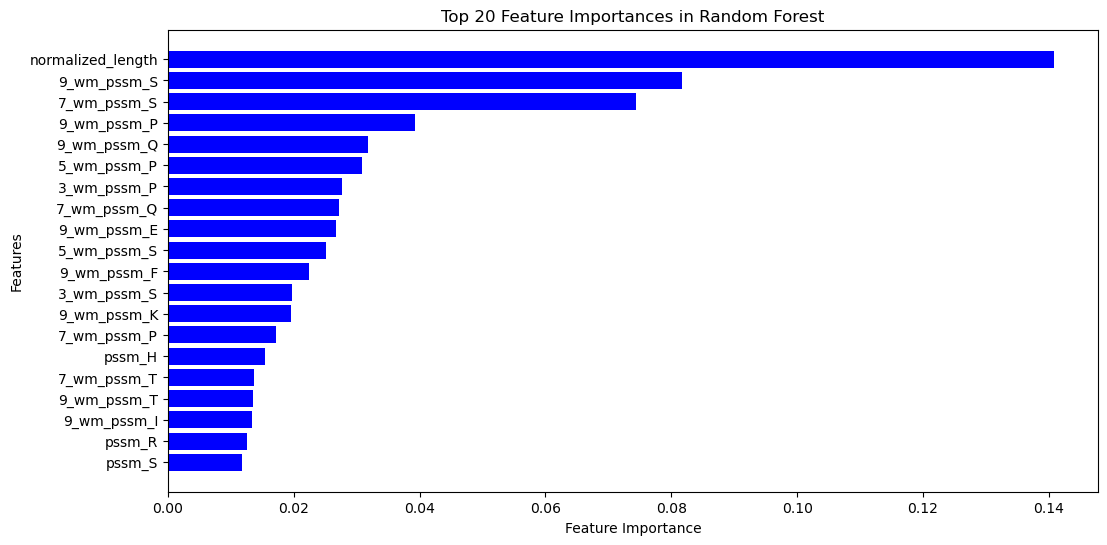

In [27]:
################## --> look at which rf we get this
importances = best_rf.feature_importances_
# Ensure you have the correct feature names
train_df_test = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names_test = train_df_test.columns  # Ensure X_train is a DataFrame

# Convert X_train (NumPy array) back to a DataFrame
X_train_names = pd.DataFrame(X_train, columns=feature_names_test)



# Create DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_test,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='blue')
plt.gca().invert_yaxis()  # Invert y-axis so the most important feature is on top
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importances in Random Forest")
plt.show()


In [33]:
"""
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)"""

'\nbackground = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]\n\n# Create SHAP DeepExplainer\nexplainer = shap.DeepExplainer(model, background)\n\n# Compute SHAP values for test data\nshap_values = explainer.shap_values(X_test)'

In [35]:
#global feature importance
"""
test_df = test_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names_2 = test_df.columns  # Ensure X_train is a DataFrame

# Convert X_train (NumPy array) back to a DataFrame
X_test_names = pd.DataFrame(X_test, columns=feature_names_2)

# Then pass them to the summary plot:
shap.summary_plot(shap_values, X_test_names)""" 

NameError: name 'shap_values' is not defined

In [37]:
def build_model(hp):
    """Build and compile a Keras model, returning it."""
    model = Sequential()

    # Tune the number of units in the first layer
    units_input = hp.Int('units_input', min_value=128, max_value=512, step=128)
    model.add(Dense(units_input, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='f1')]
    )
    return model

In [39]:
class MyHyperband(kt.Hyperband):
    """
    Custom Hyperband tuner that also tunes 'batch_size' via run_trial()
    and returns final metrics to avoid the 'None' return error.
    Now optimized for F1 score while also tracking loss.
    """

    def run_trial(self, trial, x, y, **fit_kwargs):
        hp = trial.hyperparameters

        # 1) Define any training-related hyperparameters here
        fit_kwargs['batch_size'] = hp.Choice('batch_size', [32, 64, 128])
        # Optionally tune epochs:
        # fit_kwargs['epochs'] = hp.Int('epochs', min_value=10, max_value=30, step=5)

        # 2) Build the model using the current hyperparameters
        model = self.hypermodel.build(hp)

        # 3) Train the model
        history = model.fit(x, y, **fit_kwargs)

        # 4) Retrieve final metrics from history
        # Ensure that 'val_loss' and 'val_f1' are being tracked during training
        final_val_loss = history.history['val_loss'][-1]
        final_val_f1 = history.history['val_f1'][-1]

        # 5) Update the trial with these metrics so the tuner can compare
        self.oracle.update_trial(
            trial.trial_id,
            {'val_loss': final_val_loss, 'val_f1': final_val_f1}
        )

        # 6) Return the final metrics to avoid the None return error
        return {'val_loss': final_val_loss, 'val_f1': final_val_f1}


In [41]:
tuner = MyHyperband(
    build_model,
    objective=kt.Objective("val_f1", direction="max"),
    max_epochs=20,
    factor=3,
    overwrite=True,
    directory="my_dir",
    project_name="nn_tuning"
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
################################################################################### HYPERPARAMTER TUNING ONLY FOR THE DEFAULT TRAININSDATA 
tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[stop_early],
    verbose=1
)


Trial 30 Complete [00h 00m 13s]
val_f1: 0.7143720388412476

Best val_f1 So Far: 0.7307857275009155
Total elapsed time: 00h 08m 45s


In [42]:
########################################################### get paramters from hyper 
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
param_values = best_hps.values
print(param_values)


{'units_input': 128, 'learning_rate': 0.0001, 'batch_size': 32, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [87]:
# Dictionary containing your training datasets
# Each key is a label, and the value is a tuple (X_train_current, y_train_current)
training_datasets = {
    "Original": (X_train, y_train),
    "Undersampled": (X_train_undersampled, y_train_undersampled),
    "Oversampled": (X_train_oversampled, y_train_oversampled)
}

# Define folder mapping from dataset name to folder
folder_mapping = {
    "Original": "default",
    "Undersampled": "under",
    "Oversampled": "over"
}

# Dictionaries to store the trained models, training histories, and metrics for each dataset.
trained_models = {}
histories = {}
metrics = {}

for dataset_name, (X_train_current, y_train_current) in training_datasets.items():
    print(f"\nTraining on {dataset_name} dataset:")
    
    # Build a new model using the best hyperparameters from the tuner
    best_model = tuner.hypermodel.build(best_hps)
    
    # Train the model using the current training dataset
    history = best_model.fit(
        X_train_current, y_train_current,
        batch_size=best_hps.get('batch_size'),
        epochs=50,  # Adjust epochs as needed
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        callbacks=[stop_early]
    )
    
    # Save the trained model and its history
    trained_models[dataset_name] = best_model
    histories[dataset_name] = history
    
    # --- Evaluate the trained model on the test set ---
    # Get prediction probabilities and flatten the output (for a binary classification NN)
    y_pred_probs_NN = best_model.predict(X_test).flatten()
    # Convert probabilities to binary predictions using a threshold of 0.5
    y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)
    
    # Calculate performance metrics
    accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
    precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
    recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
    f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)
    
    # Print metrics for the current dataset
    print(f"{dataset_name} - Accuracy: {accuracy_NN:.2f}")
    print(f"{dataset_name} - Precision: {precision_NN:.2f}")
    print(f"{dataset_name} - Recall: {recall_NN:.2f}")
    print(f"{dataset_name} - F1 Score: {f1_NN:.2f}")
    
    # Print the detailed classification report
    print(f"\nClassification Report for {dataset_name} dataset:")
    print(classification_report(y_test, y_pred_class_NN, zero_division=0))
    
    # Compute the ROC curve and ROC-AUC
    fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
    roc_auc_NN = auc(fpr_NN, tpr_NN)
    
    # Store metrics in a dictionary for later reference if needed
    metrics[dataset_name] = {
        "accuracy": accuracy_NN,
        "precision": precision_NN,
        "recall": recall_NN,
        "f1": f1_NN,
        "roc_auc": roc_auc_NN,
        'fpr':fpr_NN,
        'tpr':tpr_NN
    }
    
    # Plot the ROC curve for the current dataset
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Neural Network ({dataset_name})')
    plt.legend(loc='lower right')
    
    # Save the ROC curve figure in the appropriate folder
    save_path_roc = os.path.join(base_folder, folder_mapping[dataset_name], f"ROC Curve - Neural Network ({dataset_name}).png")
    plt.savefig(save_path_roc)
    plt.close()
    
    # Plot the confusion matrix for the current dataset
    cm_NN = confusion_matrix(y_test, y_pred_class_NN)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_NN, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - Neural Network ({dataset_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    
    # Save the confusion matrix figure in the appropriate folder
    save_path_cm = os.path.join(base_folder, folder_mapping[dataset_name], f"Confusion Matrix - Neural Network ({dataset_name}).png")
    plt.savefig(save_path_cm)
    plt.close()



Training on Original dataset:
Epoch 1/50


C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5294 - f1: 0.5657 - loss: 0.8443 - val_accuracy: 0.5895 - val_f1: 0.6991 - val_loss: 0.6749
Epoch 2/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5895 - f1: 0.6513 - loss: 0.7047 - val_accuracy: 0.6087 - val_f1: 0.7113 - val_loss: 0.6490
Epoch 3/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6080 - f1: 0.6747 - loss: 0.6745 - val_accuracy: 0.6261 - val_f1: 0.7200 - val_loss: 0.6304
Epoch 4/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6197 - f1: 0.6932 - loss: 0.6527 - val_accuracy: 0.6278 - val_f1: 0.7159 - val_loss: 0.6259
Epoch 5/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6303 - f1: 0.7058 - loss: 0.6357 - val_accuracy: 0.6253 - val_f1: 0.7224 - val_loss: 0.6281
Epoch 6/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6272 - f1: 0.7005 - loss: 0.6351 - val_accuracy: 0.6329 - val_f1: 0.7250 - val_loss: 0.6191
Epoch 7/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/st

C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


747/747 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5016 - f1: 0.5494 - loss: 1.1855 - val_accuracy: 0.3854 - val_f1: 0.6581 - val_loss: 0.9531
Epoch 2/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4759 - f1: 0.6336 - loss: 0.9376 - val_accuracy: 0.3262 - val_f1: 0.6994 - val_loss: 1.0580
Epoch 3/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4604 - f1: 0.6604 - loss: 0.8810 - val_accuracy: 0.3122 - val_f1: 0.7099 - val_loss: 1.0834
Epoch 4/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4584 - f1: 0.6712 - loss: 0.8627 - val_accuracy: 0.3184 - val_f1: 0.7112 - val_loss: 1.0941
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
Undersampled - Accuracy: 0.47
Undersampled - Precision: 0.15
Undersampled - Recall: 0.81
Undersampled - F1 Score: 0.26

Classification Report for Undersampled dataset:
              precision    recall  f1-score   support

           0       0.94      0.42      0.58      6394
           1       0.15      0.81      0.26       823

    

C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1918/1918 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4989 - f1: 0.5990 - loss: 1.0390 - val_accuracy: 0.3393 - val_f1: 0.7000 - val_loss: 1.0740
Epoch 2/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4801 - f1: 0.7013 - loss: 0.8232 - val_accuracy: 0.3557 - val_f1: 0.7172 - val_loss: 1.0439
Epoch 3/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5016 - f1: 0.7316 - loss: 0.7824 - val_accuracy: 0.3795 - val_f1: 0.7164 - val_loss: 1.0143
Epoch 4/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5124 - f1: 0.7471 - loss: 0.7623 - val_accuracy: 0.3816 - val_f1: 0.7185 - val_loss: 1.0075
Epoch 5/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5181 - f1: 0.7562 - loss: 0.7489 - val_accuracy: 0.3927 - val_f1: 0.7122 - val_loss: 0.9857
Epoch 6/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5285 - f1: 0.7671 - loss: 0.7368 - val_accuracy: 0.3945 - val_f1: 0.7156 - val_loss: 0.9747
Epoch 7/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/st

In [44]:
#############################################use shap for other model

# Create SHAP DeepExplainer --> now uses last of the best models
explainer = shap.DeepExplainer(best_model, background)

# Compute SHAP values for test data
shap_values_2 = explainer.shap_values(X_test)

C:\Users\youpz\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_363
Received: inputs=['Tensor(shape=(100, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_363
Received: inputs=['Tensor(shape=(200, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_363
Received: inputs=['Tensor(shape=(7217

<Figure size 640x480 with 0 Axes>

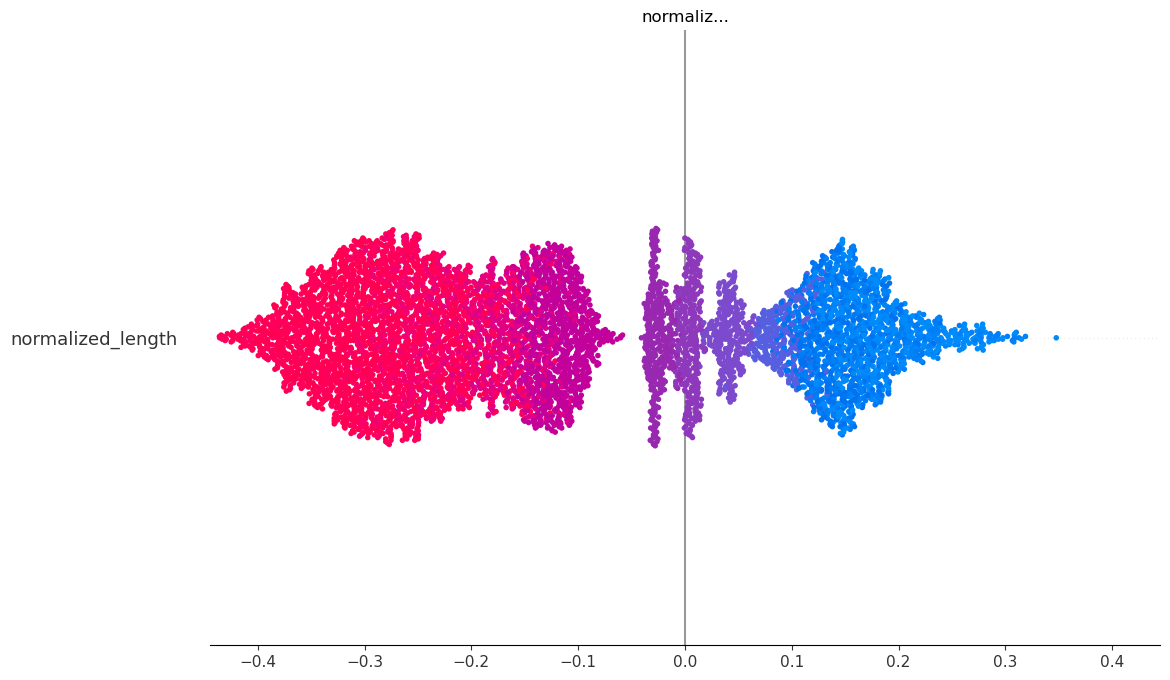

In [45]:
# Then pass them to the summary plot:
shap.summary_plot(shap_values_2, X_test_names)

In [46]:
################################################## getting normelized lenght
X_train_length = X_train[:, 0].reshape(-1, 1)  
X_test_length  = X_test[:, 0].reshape(-1, 1) 


In [47]:
################################################## running logistic regression with one variable
model_single = LogisticRegression()
model_single.fit(X_train_length, y_train)
y_pred_probs_LR_single = model_single.predict_proba(X_test_length)[:, 1]
y_pred_class_LR_single = (y_pred_probs_LR_single >= 0.5).astype(int)

In [48]:


# Convert to binary predictions using a threshold of 0.5


# Evaluate with "LR_single" variable names
accuracy_LR_single  = accuracy_score(y_test, y_pred_class_LR_single)
precision_LR_single = precision_score(y_test, y_pred_class_LR_single, zero_division=0)
recall_LR_single    = recall_score(y_test, y_pred_class_LR_single, zero_division=0)
f1_LR_single        = f1_score(y_test, y_pred_class_LR_single, zero_division=0)

print("Accuracy (LR_single):", accuracy_LR_single)
print("Precision (LR_single):", precision_LR_single)
print("Recall (LR_single):", recall_LR_single)
print("F1 (LR_single):", f1_LR_single)

#print classification report
print(classification_report(y_test, y_pred_class_LR_single, zero_division=0))

Accuracy (LR_single): 0.8859636968269364
Precision (LR_single): 0.0
Recall (LR_single): 0.0
F1 (LR_single): 0.0
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



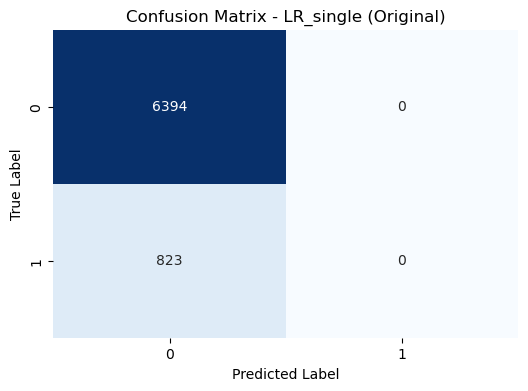

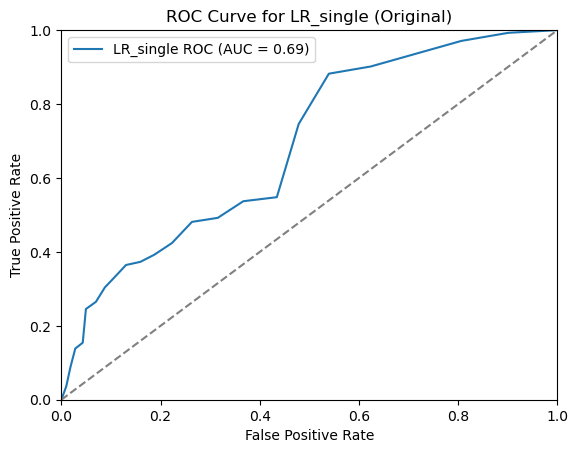

In [49]:
################################################## print results Linear regression
print(classification_report(y_test, y_pred_class_LR_single, zero_division=0))

# 2. Compute ROC curve with continuous probabilities
fpr_LR_single, tpr_LR_single, thresholds_LR_single = roc_curve(y_test, y_pred_probs_LR_single)
roc_auc_LR_single = auc(fpr_LR_single, tpr_LR_single)


cm_LR_single = confusion_matrix(y_test, y_pred_class_LR_single)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_LR_single, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - LR_single (Original)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "default", "Confusion Matrix - LR_single (Original).png"))

plt.show()

# 3. Plot the ROC curve
plt.plot(fpr_LR_single, tpr_LR_single, label=f"LR_single ROC (AUC = {roc_auc_LR_single:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LR_single (Original)")  # This adds the title
plt.legend()
plt.savefig(os.path.join(base_folder, "default", "ROC Curve - LR_single (Original).png"))

plt.show()

Undersampled - Accuracy (LR_single): 0.8859636968269364
Undersampled - Precision (LR_single): 0.0
Undersampled - Recall (LR_single): 0.0
Undersampled - F1 (LR_single): 0.0
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



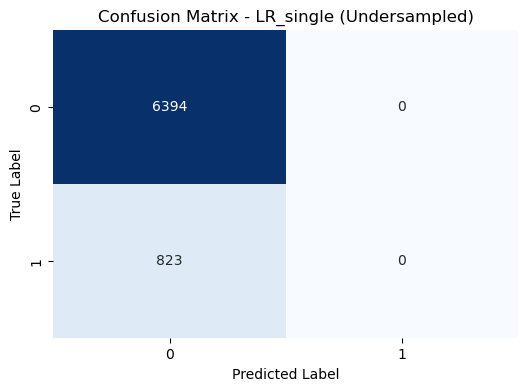

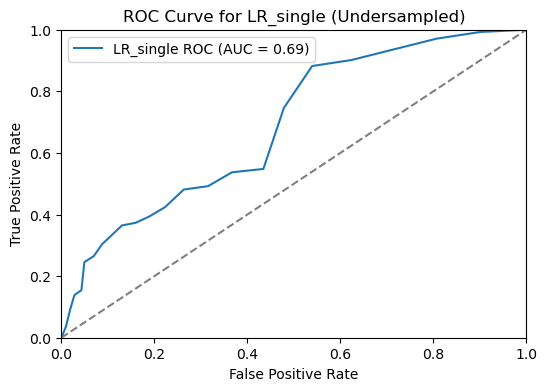

In [59]:
#####################################################
# Single logistic regression normalized length (undersampled)
#####################################################

# Prepare the undersampled training set

# Get normalized length (assuming the first column is the length feature)
# Use numpy indexing instead of .iloc for NumPy arrays
X_train_length_under = X_train_undersampled[:, 0].reshape(-1, 1)
X_test_length = X_test[:, 0].reshape(-1, 1)  # Assuming X_test remains unchanged

# Run logistic regression using the single variable (length) on undersampled data
model_single_under = LogisticRegression()
model_single_under.fit(X_train_length_under, y_train_undersampled)
y_pred_probs_LR_single_under = model_single_under.predict_proba(X_test_length)[:, 1]
y_pred_class_LR_single_under = (y_pred_probs_LR_single_under >= 0.5).astype(int)

# Evaluate the model
accuracy_LR_single_under  = accuracy_score(y_test, y_pred_class_LR_single_under)
precision_LR_single_under = precision_score(y_test, y_pred_class_LR_single_under, zero_division=0)
recall_LR_single_under    = recall_score(y_test, y_pred_class_LR_single_under, zero_division=0)
f1_LR_single_under        = f1_score(y_test, y_pred_class_LR_single_under, zero_division=0)

print("Undersampled - Accuracy (LR_single):", accuracy_LR_single_under)
print("Undersampled - Precision (LR_single):", precision_LR_single_under)
print("Undersampled - Recall (LR_single):", recall_LR_single_under)
print("Undersampled - F1 (LR_single):", f1_LR_single_under)
print(classification_report(y_test, y_pred_class_LR_single_under, zero_division=0))

# Compute and plot confusion matrix for LR_single (Undersampled)
cm_LR_single_under = confusion_matrix(y_test, y_pred_class_LR_single_under)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_LR_single_under, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - LR_single (Undersampled)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "under", "Confusion Matrix - LR_single (Undersampled).png"))
plt.show()

# Compute ROC curve and AUC
fpr_LR_single_under, tpr_LR_single_under, thresholds_LR_single_under = roc_curve(y_test, y_pred_probs_LR_single_under)
roc_auc_LR_single_under = auc(fpr_LR_single_under, tpr_LR_single_under)

# Plot the ROC curve for the undersampled model
plt.figure(figsize=(6, 4))
plt.plot(fpr_LR_single_under, tpr_LR_single_under, label=f"LR_single ROC (AUC = {roc_auc_LR_single_under:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LR_single (Undersampled)")
plt.legend()
plt.savefig(os.path.join(base_folder, "under", "ROC Curve - LR_single (Undersampled).png"))
plt.show()


Oversampled - Accuracy (LR_single): 0.8798669807399196
Oversampled - Precision (LR_single): 0.38421052631578945
Oversampled - Recall (LR_single): 0.08869987849331713
Oversampled - F1 (LR_single): 0.1441263573543929
              precision    recall  f1-score   support

           0       0.89      0.98      0.94      6394
           1       0.38      0.09      0.14       823

    accuracy                           0.88      7217
   macro avg       0.64      0.54      0.54      7217
weighted avg       0.84      0.88      0.85      7217



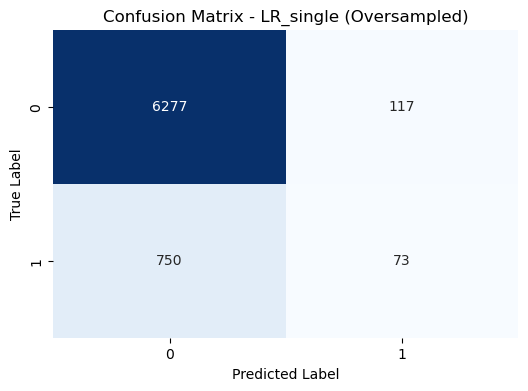

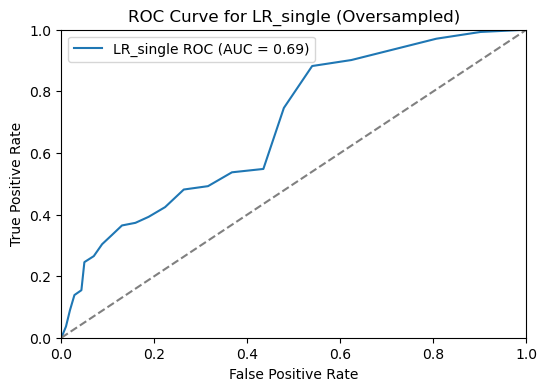

In [63]:
#####################################################
# Single logistic regression normalized length (oversampled)
#####################################################

# Prepare the oversampled training set
# Get normalized length (assuming the first column is the length feature)
X_train_length_over = X_train_oversampled[:, 0].reshape(-1, 1)
X_test_length = X_test[:, 0].reshape(-1, 1)  # Assuming X_test remains unchanged

# Run logistic regression using the single variable (length) on oversampled data
model_single_over = LogisticRegression()
model_single_over.fit(X_train_length_over, y_train_oversampled)
y_pred_probs_LR_single_over = model_single_over.predict_proba(X_test_length)[:, 1]
y_pred_class_LR_single_over = (y_pred_probs_LR_single_over >= 0.5).astype(int)

# Evaluate the model
accuracy_LR_single_over  = accuracy_score(y_test, y_pred_class_LR_single_over)
precision_LR_single_over = precision_score(y_test, y_pred_class_LR_single_over, zero_division=0)
recall_LR_single_over    = recall_score(y_test, y_pred_class_LR_single_over, zero_division=0)
f1_LR_single_over        = f1_score(y_test, y_pred_class_LR_single_over, zero_division=0)

print("Oversampled - Accuracy (LR_single):", accuracy_LR_single_over)
print("Oversampled - Precision (LR_single):", precision_LR_single_over)
print("Oversampled - Recall (LR_single):", recall_LR_single_over)
print("Oversampled - F1 (LR_single):", f1_LR_single_over)
print(classification_report(y_test, y_pred_class_LR_single_over, zero_division=0))

# Compute and plot confusion matrix for LR_single (Oversampled)
cm_LR_single_over = confusion_matrix(y_test, y_pred_class_LR_single_over)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_LR_single_over, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - LR_single (Oversampled)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(base_folder, "over", "Confusion Matrix - LR_single (Oversampled).png"))
plt.show()

# Compute ROC curve and AUC
fpr_LR_single_over, tpr_LR_single_over, thresholds_LR_single_over = roc_curve(y_test, y_pred_probs_LR_single_over)
roc_auc_LR_single_over = auc(fpr_LR_single_over, tpr_LR_single_over)

# Plot the ROC curve for the oversampled model
plt.figure(figsize=(6, 4))
plt.plot(fpr_LR_single_over, tpr_LR_single_over, label=f"LR_single ROC (AUC = {roc_auc_LR_single_over:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LR_single (Oversampled)")
plt.legend()
plt.savefig(os.path.join(base_folder, "over", "ROC Curve - LR_single (Oversampled).png"))
plt.show()


In [65]:
################################################################################## permutation test using AUC frop
def permutation_importance_keras_auc(model, X, y, n_repeats=5, random_state=42):
    """
    model to see which features let the AUC drop most
    """
    #  Compute baseline AUC
    baseline_probs = model.predict(X).ravel()  # probabilities
    baseline_auc = roc_auc_score(y, baseline_probs)

    #random 
    rng = np.random.default_rng(random_state)
    importances = np.zeros(X.shape[1])

    # For each feature i shuffle it and measure AUC drop
    for i in range(X.shape[1]):
        score_decreases = []
        for _ in range(n_repeats):
            X_permuted = X.copy()  
            rng.shuffle(X_permuted[:, i])  
            perm_probs = model.predict(X_permuted).ravel()
            perm_auc = roc_auc_score(y, perm_probs)

            # how much dit the auc drop
            score_decreases.append(baseline_auc - perm_auc)

        # avarage drop feature in auc
        importances[i] = np.mean(score_decreases)
        
    #return outcome
    return importances, baseline_auc

In [67]:
########################################## running permutation test
importances, baseline_auc = permutation_importance_keras_auc(best_model, X_test, y_test)

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
226/226 ━━━

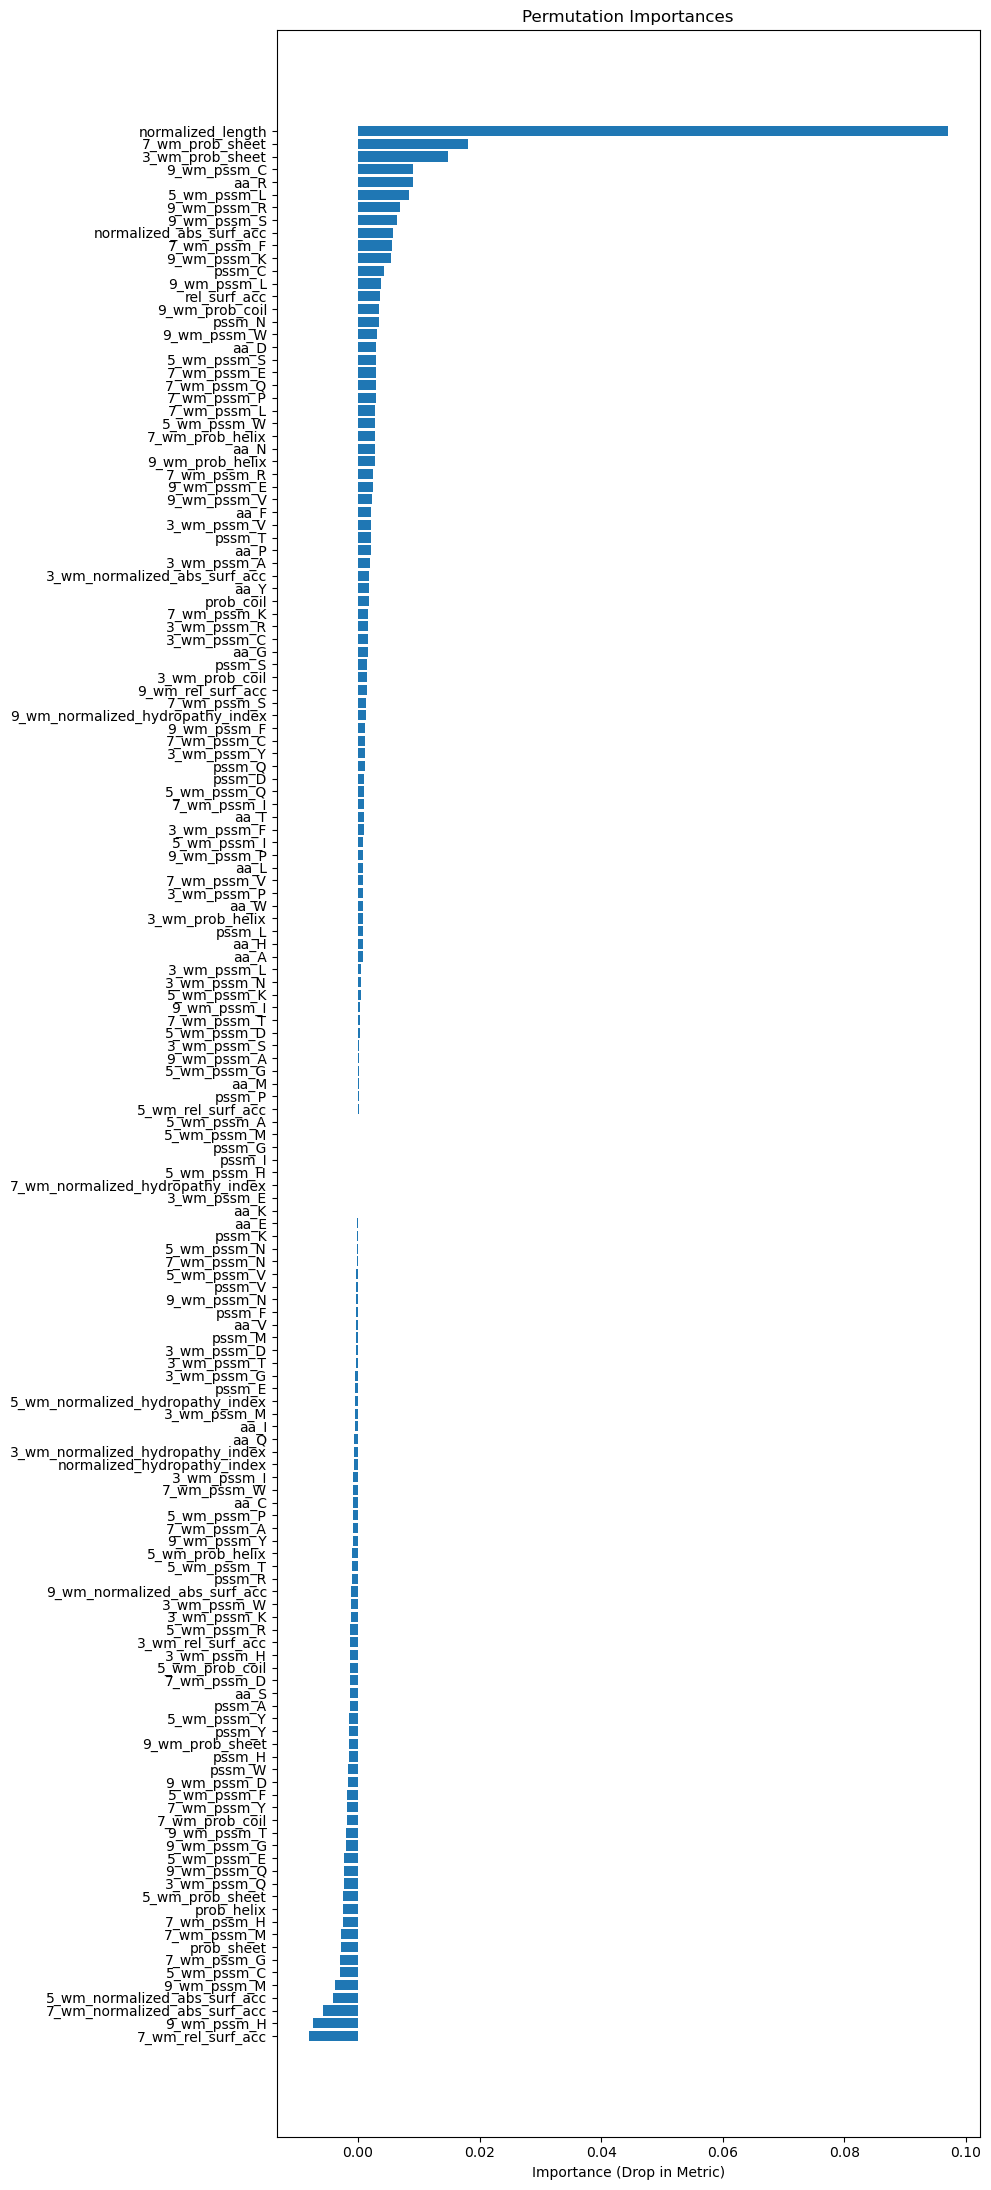

In [68]:
############################################################## sort importance and plot inmpact

def plot_permutation_importances(importances, feature_names, title="Permutation Importances"):
    indices = np.argsort(importances)[::-1]  # sort descending
    sorted_importances = importances[indices]
    sorted_features = [feature_names[i] for i in indices]

    # make iit horizonontal and big so you read the names
    plt.figure(figsize=(10, 22))
   
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_features)
    
    plt.gca().invert_yaxis()
    
    plt.xlabel("Importance (Drop in Metric)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_permutation_importances(importances, feature_names_test)

In [69]:
# Remove the 'normalized_length' feature
X_train_without_length = np.delete(X_train, 0, axis=1)  
X_val_without_length   = np.delete(X_val, 0, axis=1)
X_test_without_length  = np.delete(X_test, 0, axis=1)

train_df_without_length = train_df_test.drop('normalized_length', axis=1)
feature_names_without_length = train_df_without_length.columns 

Epoch 1/50


C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1614/1614 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5275 - auc: 0.5600 - loss: 0.7642 - val_accuracy: 0.4721 - val_auc: 0.6066 - val_loss: 0.6704
Epoch 2/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5194 - auc: 0.6299 - loss: 0.6616 - val_accuracy: 0.4866 - val_auc: 0.6196 - val_loss: 0.6711
Epoch 3/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5375 - auc: 0.6559 - loss: 0.6506 - val_accuracy: 0.5403 - val_auc: 0.6268 - val_loss: 0.6509
Epoch 4/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5526 - auc: 0.6694 - loss: 0.6408 - val_accuracy: 0.5270 - val_auc: 0.6171 - val_loss: 0.6578
Epoch 5/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5468 - auc: 0.6734 - loss: 0.6429 - val_accuracy: 0.5704 - val_auc: 0.6231 - val_loss: 0.6391
Epoch 6/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5699 - auc: 0.6857 - loss: 0.6350 - val_accuracy: 0.5704 - val_auc: 0.6152 - val_loss: 0.6418
Epoch 7/50
1614/1614 ━━━━━━━━━━━━━━━━━━

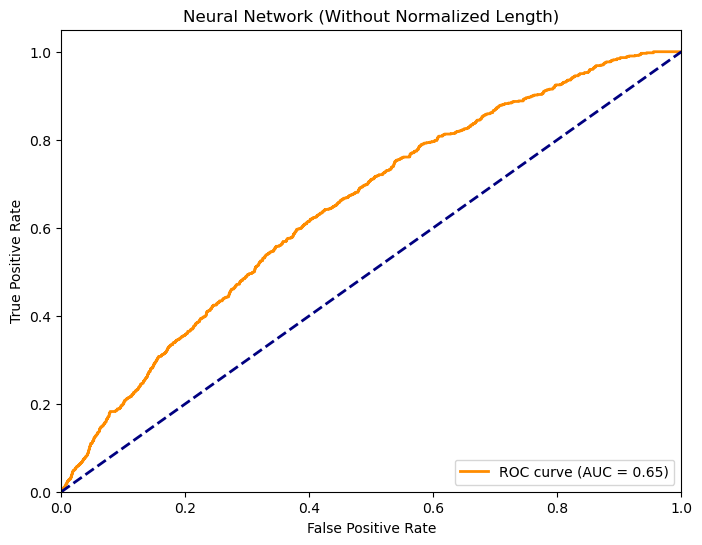

In [70]:
######################################################## Trying NN without normalized length

# Make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_without_length.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])


# Train model and set the class weights
history = model.fit(
    X_train_without_length, y_train,
    validation_data=(X_val_without_length, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)

# caluculate scores neural network
y_pred_probs_NN = model.predict(X_test_without_length).flatten()  # Continuous outputs, shape = (num_samples,)

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)

# print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))

# Compute and plot ROC curve (using continuous probabilities)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network (Without Normalized Length)')
plt.legend(loc='lower right')
plt.show()


In [71]:
########################################## running permutation test
importances2, baseline_auc2 = permutation_importance_keras_auc(model, X_test_without_length, y_test)

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
226/226 ━━━

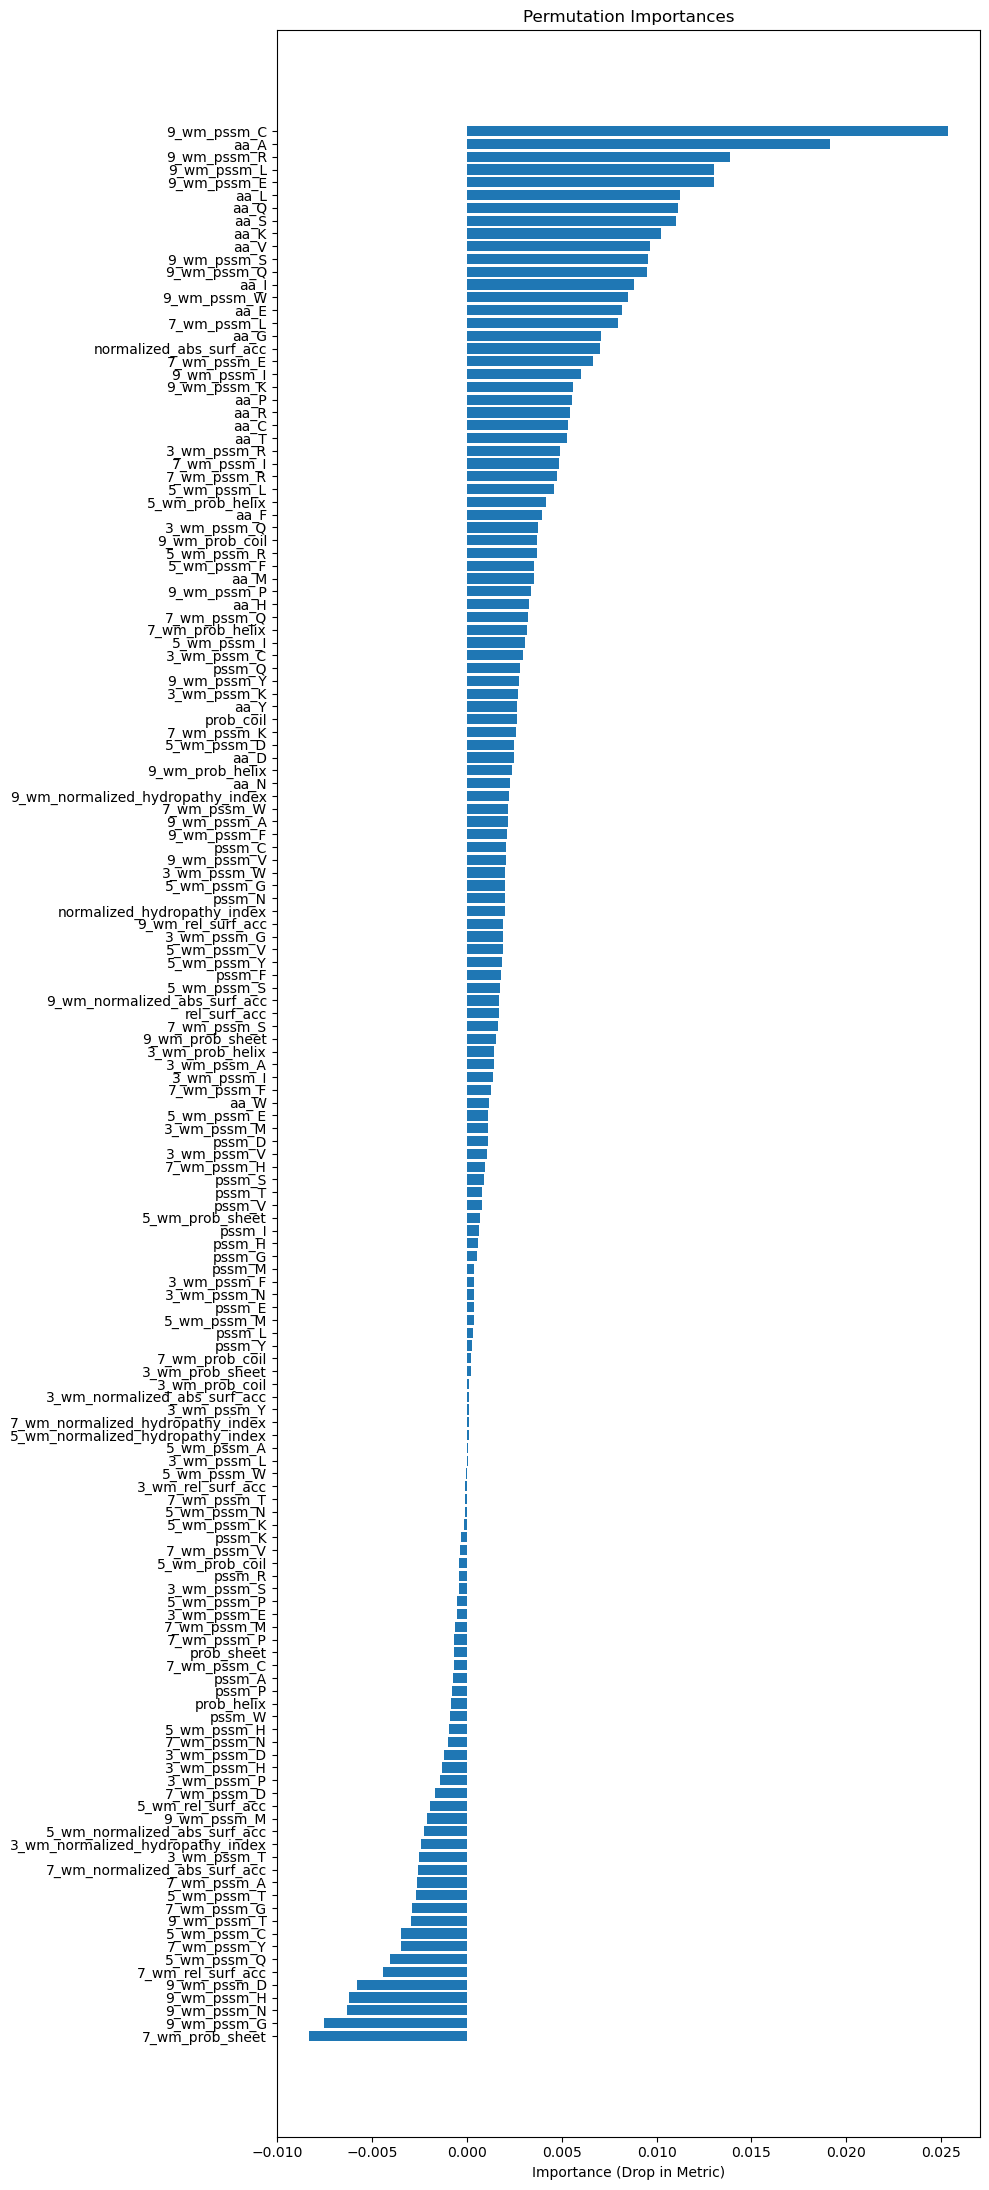

In [72]:
plot_permutation_importances(importances2, feature_names_without_length)

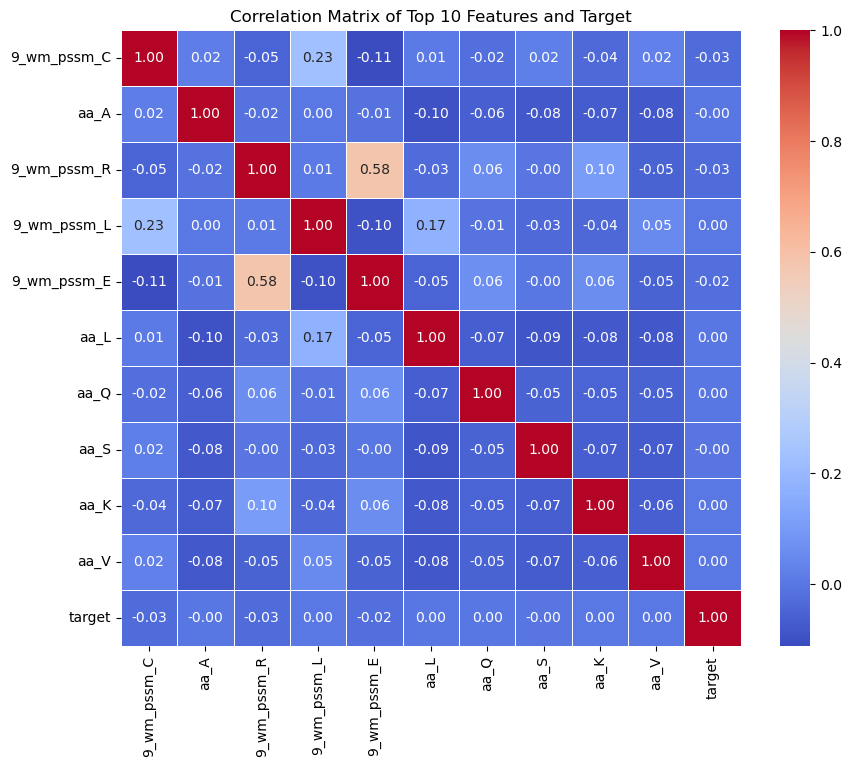

       Feature  T-Statistic       P-Value
0  9_wm_pssm_C    11.718510  1.787233e-31
4  9_wm_pssm_E     9.814938  1.275178e-22
2  9_wm_pssm_R     9.444882  4.521722e-21
7         aa_S     7.130608  1.078652e-12
1         aa_A     7.090407  1.442313e-12
3  9_wm_pssm_L     5.722819  1.083931e-08
9         aa_V     3.741143  1.844111e-04
5         aa_L     2.007078  4.477438e-02
8         aa_K    -1.758257  7.874300e-02
6         aa_Q    -1.443938  1.487966e-01


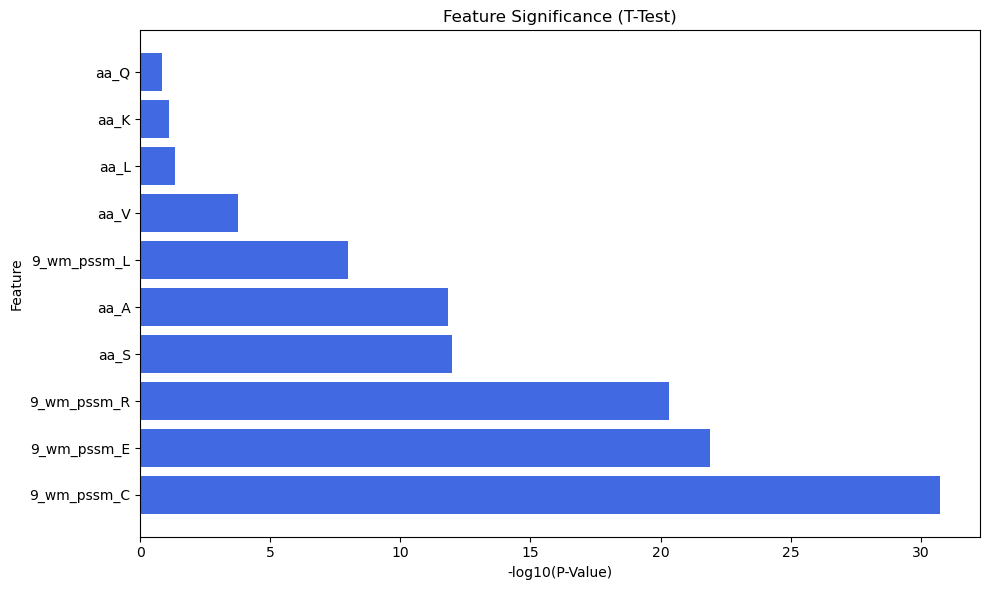

In [73]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt


# Select the top 10 important features based on permutation importances
top_10_indices = np.argsort(importances2)[::-1][:10]  # Get indices of top 10 features
top_10_feature_names = [feature_names_without_length[i] for i in top_10_indices]
top_10_importances = importances2[top_10_indices]

# Select the columns (features) corresponding to the top 10 features using the indices
selected_features = X_train_without_length[:, top_10_indices]

# Convert to DataFrame for easier handling
selected_features_df = pd.DataFrame(selected_features, columns=top_10_feature_names)
selected_features_df['target'] = y_train

# Step 3: Compute the correlation matrix
correlation_matrix = selected_features_df.corr()

# Step 4: Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Top 10 Features and Target')
plt.savefig(os.path.join(base_folder,  "'Correlation Matrix of Top 10 Features and Target'"))
plt.show()


t_stats = []
p_values = []

for feature in top_10_feature_names:
    # Find the index of the feature name
    feature_idx = np.where(feature_names_without_length == feature)[0][0]
    
    # Get the feature values for each class
    class_0 = X_train_without_length[y_train == 0, feature_idx]
    class_1 = X_train_without_length[y_train == 1, feature_idx]
    
    # Perform Welch's t-test 
    t_stat, p_value = ttest_ind(class_0, class_1, equal_var=False)
    
    t_stats.append(t_stat)
    p_values.append(p_value)


# Create a DataFrame for easier visualization
t_test_results = pd.DataFrame({
    "Feature": top_10_feature_names,
    "T-Statistic": t_stats,
    "P-Value": p_values
})

# Sort the DataFrame by P-Value for better interpretation
t_test_results = t_test_results.sort_values(by="P-Value")

# Print the top significant features
print(t_test_results)

# plot the p-values for each feature
plt.figure(figsize=(10, 6))
plt.barh(t_test_results["Feature"], -np.log10(t_test_results["P-Value"]), color='royalblue')
plt.xlabel("-log10(P-Value)")
plt.ylabel("Feature")
plt.title("Feature Significance (T-Test)")
plt.tight_layout()
plt.savefig(os.path.join(base_folder,  "Feature Significance (T-Test)"))
plt.show()

C:\Users\youpz\AppData\Local\Temp\ipykernel_1776\1677375008.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(sorted_models, rotation=45, ha='right')
C:\Users\youpz\AppData\Local\Temp\ipykernel_1776\1677375008.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(sorted_models, rotation=45, ha='right')
C:\Users\youpz\AppData\Local\Temp\ipykernel_1776\1677375008.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(sorted_models, rotation=45, ha='right')


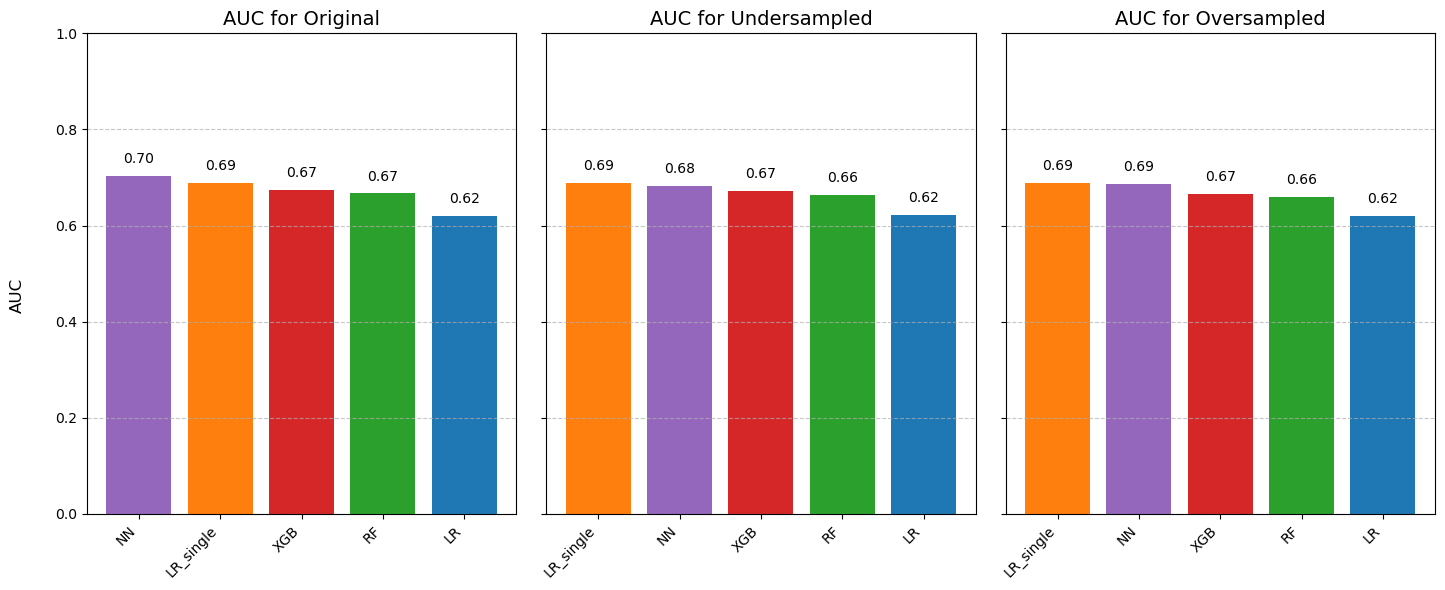

In [74]:
# Example: Replace these variables with your actual computed AUC values
auc_metrics = {
    "Original": {
        "LR": roc_auc_LR,                      # AUC for standard Logistic Regression (Original)
        "LR_single": roc_auc_LR_single,        # AUC for single-variable LR (Original)
        "RF": roc_auc_RF,                      # AUC for Random Forest (Original)
        "XGB": roc_auc_XGB,                    # AUC for XGBoost (Original)
        "NN": metrics["Original"]["roc_auc"]     # AUC for Neural Network (Original)
    },
    "Undersampled": {
        "LR": roc_auc_LR_under,                # AUC for standard Logistic Regression (Undersampled)
        "LR_single": roc_auc_LR_single_under,  # AUC for single-variable LR (Undersampled)
        "RF": roc_auc_RF_under,                # AUC for Random Forest (Undersampled)
        "XGB": roc_auc_XGB_under,              # AUC for XGBoost (Undersampled)
        "NN": metrics["Undersampled"]["roc_auc"]  # AUC for Neural Network (Undersampled)
    },
    "Oversampled": {
        "LR": roc_auc_LR_over,                 # AUC for standard Logistic Regression (Oversampled)
        "LR_single": roc_auc_LR_single_over,   # AUC for single-variable LR (Oversampled)
        "RF": roc_auc_RF_over,                 # AUC for Random Forest (Oversampled)
        "XGB": roc_auc_XGB_over,               # AUC for XGBoost (Oversampled)
        "NN": metrics["Oversampled"]["roc_auc"]   # AUC for Neural Network (Oversampled)
    }
}
color_dict = {
    "LR": "tab:blue",
    "LR_single": "tab:orange",
    "RF": "tab:green",
    "XGB": "tab:red",
    "NN": "tab:purple"
}
datasets = list(auc_metrics.keys())
num_datasets = len(datasets)

fig, axes = plt.subplots(nrows=1, ncols=num_datasets, figsize=(5 * num_datasets, 6), sharey=True)

# If there's only one dataset, axes won't be a list; convert it to a list
if num_datasets == 1:
    axes = [axes]

for i, dataset in enumerate(datasets):
    # Sort the models by AUC (descending)
    sorted_data = sorted(auc_metrics[dataset].items(), key=lambda x: x[1], reverse=True)
    sorted_models, sorted_aucs = zip(*sorted_data)

    # Determine colors for the bars based on the model name
    bar_colors = [color_dict[m] for m in sorted_models]

    # Create a bar chart for this dataset
    axes[i].bar(sorted_models, sorted_aucs, color=bar_colors)
    axes[i].set_title(f"AUC for {dataset}", fontsize=14)
    axes[i].set_ylim(0, 1.0)

    # Rotate model labels for readability if needed
    axes[i].set_xticklabels(sorted_models, rotation=45, ha='right')

    # Add gridlines on the y-axis
    axes[i].yaxis.grid(True, linestyle='--', alpha=0.7)

    # Annotate each bar with its AUC value
    for j, val in enumerate(sorted_aucs):
        axes[i].text(j, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

# Add a single shared y-label for all subplots
fig.text(0.04, 0.5, "AUC", va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 1])  # Make room for the shared y-label

# Save the figure with a tight bounding box so labels aren't cut off
plt.savefig(os.path.join(base_folder, "Comparison_AUC_all_models_per_dataset.png"), bbox_inches='tight')
plt.show()

C:\Users\youpz\AppData\Local\Temp\ipykernel_1776\4151632857.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(sorted_models, rotation=45, ha='right')
C:\Users\youpz\AppData\Local\Temp\ipykernel_1776\4151632857.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(sorted_models, rotation=45, ha='right')
C:\Users\youpz\AppData\Local\Temp\ipykernel_1776\4151632857.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(sorted_models, rotation=45, ha='right')


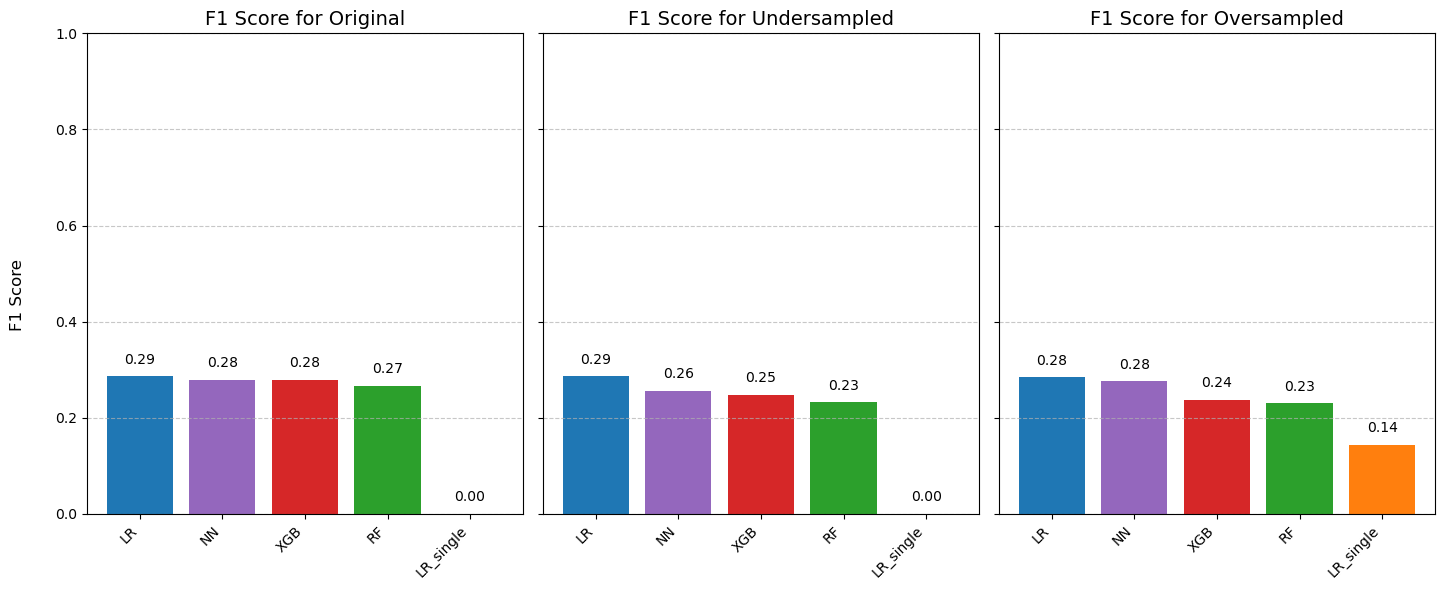

In [105]:
f1_metrics = {
    "Original": {
        "LR": f1_LR,                      # F1 for standard Logistic Regression (Original)
        "LR_single": f1_LR_single,        # F1 for single-variable LR (Original)
        "RF": f1_RF,                      # F1 for Random Forest (Original)
        "XGB": f1_XGB,                    # F1 for XGBoost (Original)
        "NN": metrics["Original"]["f1"]   # F1 for Neural Network (Original)
    },
    "Undersampled": {
        "LR": f1_LR_under,                # F1 for standard Logistic Regression (Undersampled)
        "LR_single": f1_LR_single_under,  # F1 for single-variable LR (Undersampled)
        "RF": f1_RF_under,                # F1 for Random Forest (Undersampled)
        "XGB": f1_XGB_under,              # F1 for XGBoost (Undersampled)
        "NN": metrics["Undersampled"]["f1"]  # F1 for Neural Network (Undersampled)
    },
    "Oversampled": {
        "LR": f1_LR_over,                 # F1 for standard Logistic Regression (Oversampled)
        "LR_single": f1_LR_single_over,   # F1 for single-variable LR (Oversampled)
        "RF": f1_RF_over,                 # F1 for Random Forest (Oversampled)
        "XGB": f1_XGB_over,               # F1 for XGBoost (Oversampled)
        "NN": metrics["Oversampled"]["f1"]   # F1 for Neural Network (Oversampled)
    }
}

# Same color dictionary as before
color_dict = {
    "LR": "tab:blue",
    "LR_single": "tab:orange",
    "RF": "tab:green",
    "XGB": "tab:red",
    "NN": "tab:purple"
}

datasets = list(f1_metrics.keys())
num_datasets = len(datasets)

fig, axes = plt.subplots(nrows=1, ncols=num_datasets, figsize=(5 * num_datasets, 6), sharey=True)

# If there's only one dataset, axes won't be a list; convert it to a list
if num_datasets == 1:
    axes = [axes]

for i, dataset in enumerate(datasets):
    # Sort the models by F1 (descending)
    sorted_data = sorted(f1_metrics[dataset].items(), key=lambda x: x[1], reverse=True)
    sorted_models, sorted_f1s = zip(*sorted_data)

    # Determine colors for the bars based on the model name
    bar_colors = [color_dict[m] for m in sorted_models]

    # Create a bar chart for this dataset
    axes[i].bar(sorted_models, sorted_f1s, color=bar_colors)
    axes[i].set_title(f"F1 Score for {dataset}", fontsize=14)
    axes[i].set_ylim(0, 1.0)

    # Rotate model labels for readability if needed
    axes[i].set_xticklabels(sorted_models, rotation=45, ha='right')

    # Add gridlines on the y-axis
    axes[i].yaxis.grid(True, linestyle='--', alpha=0.7)

    # Annotate each bar with its F1 value
    for j, val in enumerate(sorted_f1s):
        axes[i].text(j, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

# Add a single shared y-label for all subplots
fig.text(0.04, 0.5, "F1 Score", va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 1])  # Make room for the shared y-label

# Save the figure with a tight bounding box so labels aren't cut off
plt.savefig(os.path.join(base_folder, "Comparison_F1_all_models_per_dataset.png"), bbox_inches='tight')
plt.show()